In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
#from numpy import array, hstack, math
#from numpy.random import uniform
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score,RepeatedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn import set_config
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor,RegressorChain
import lightgbm as lgb


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('precision', 2)

In [2]:
#Read the csv file
df=pd.read_csv('C:/Users/ravip/Desktop/Florida_Orlando_Data.csv' , skiprows=9)
print(df.head(5))

       timestamp  Temp_2m  RH_2m  MSL_Pressure  Precipitation_Total  Snowfall  \
0  20000101T0000    18.45     73        1021.9                  0.0         0   
1  20000101T0100    18.02     75        1022.0                  0.0         0   
2  20000101T0200    17.55     77        1021.9                  0.0         0   
3  20000101T0300    17.03     80        1021.5                  0.0         0   
4  20000101T0400    16.57     82        1021.5                  0.0         0   

   total_cld_lay  high_cld_lay  mid_cld_lay  low_cld_lay  Sunshine_Duration  \
0           18.0             0            0           18                0.0   
1           20.0             0            0           20                0.0   
2           21.0             0            0           21                0.0   
3           15.0             0            0           15                0.0   
4           25.0             0            0           25                0.0   

   Shortwave_Radiation  Direct_Shortwa

<H1>Exploratory Analysis</H1>

In [3]:
#convert the timestamp object type variable into a date time variable to extract year, month, day and time. 
df['timestamp'] =  pd.to_datetime(df['timestamp'])
df['day'] = df['timestamp'].dt.day
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

def hr_func(ts):
    return ts.hour

df['hour_of_day'] = df['timestamp'].apply(hr_func)

In [4]:
#drop the columns that have no data or which are irrelevant to the study
#snowfall feature does not have any data since Orlando is a sub tropical location which does not get any snowfall. 
#time stamp feature has been extracted into multiple fields for the ease of analysis and hence this field will be dropped as it has string data that is no longer needed for processing. 
data = df.drop(['timestamp', 'Snowfall'], axis=1)
print(data.head(5))

   Temp_2m  RH_2m  MSL_Pressure  Precipitation_Total  total_cld_lay  \
0    18.45     73        1021.9                  0.0           18.0   
1    18.02     75        1022.0                  0.0           20.0   
2    17.55     77        1021.9                  0.0           21.0   
3    17.03     80        1021.5                  0.0           15.0   
4    16.57     82        1021.5                  0.0           25.0   

   high_cld_lay  mid_cld_lay  low_cld_lay  Sunshine_Duration  \
0             0            0           18                0.0   
1             0            0           20                0.0   
2             0            0           21                0.0   
3             0            0           15                0.0   
4             0            0           25                0.0   

   Shortwave_Radiation  Direct_Shortwave_Radiation  \
0                  0.0                         0.0   
1                  0.0                         0.0   
2                  0.0    

In [5]:
#check for the info regarding the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182448 entries, 0 to 182447
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Temp_2m                      182448 non-null  float64
 1   RH_2m                        182448 non-null  int64  
 2   MSL_Pressure                 182448 non-null  float64
 3   Precipitation_Total          182448 non-null  float64
 4   total_cld_lay                182448 non-null  float64
 5   high_cld_lay                 182448 non-null  int64  
 6   mid_cld_lay                  182448 non-null  int64  
 7   low_cld_lay                  182448 non-null  int64  
 8   Sunshine_Duration            182448 non-null  float64
 9   Shortwave_Radiation          182448 non-null  float64
 10  Direct_Shortwave_Radiation   182448 non-null  float64
 11  Diffuse_Shortwave_Radiation  182448 non-null  float64
 12  Evptrp                       182448 non-null  float64
 13 

In [6]:
#check for any missing or null values in the features and labels. 
data.isnull().sum()

Temp_2m                        0
RH_2m                          0
MSL_Pressure                   0
Precipitation_Total            0
total_cld_lay                  0
high_cld_lay                   0
mid_cld_lay                    0
low_cld_lay                    0
Sunshine_Duration              0
Shortwave_Radiation            0
Direct_Shortwave_Radiation     0
Diffuse_Shortwave_Radiation    0
Evptrp                         0
FAO_Ref_Evptrp_2m              0
CAPE                           0
Wind_Gust                      0
Wind_Speed_10m                 0
Wind_Dir_10m                   0
Wind_Speed_80m                 0
Wind_Dir_80m                   0
Wind_Speed_900mb               0
Wind_Dir_900mb                 0
Wind_Speed_850mb               0
Wind_Dir_850mb                 0
Wind_Speed_700_mb]             0
Wind_Dir_700mb                 0
Wind_Speed_500mb               0
Wind_Dir_500mb                 0
GP_Height_1000mb               0
GP_Height_850mb                0
GP_Height_

### Upon examining no categorical data is observed in any of the columns. Also, none of the columns seems to have any missing values. 

In [7]:
#drop any duplicate records from the data
data = data.drop_duplicates()
data.shape

(182448, 43)

## It can be seen that the data has well balanced row vs. column proportions.

In [8]:
data.describe()

Temp_2m      RH_2m  MSL_Pressure  Precipitation_Total  total_cld_lay  \
count  182448.00  182448.00     182448.00            182448.00      182448.00   
mean       22.13      72.87       1017.76                 0.07          41.77   
std         6.28      17.89          4.37                 0.38          42.98   
min        -6.25      14.00        975.60                 0.00           0.00   
25%        18.45      59.00       1014.90                 0.00           0.90   
50%        23.04      75.00       1017.50                 0.00          16.20   
75%        26.66      89.00       1020.40                 0.00         100.00   
max        39.00     100.00       1037.10                27.60         100.00   

       high_cld_lay  mid_cld_lay  low_cld_lay  Sunshine_Duration  \
count     182448.00    182448.00    182448.00          182448.00   
mean          25.71        24.06        28.87              16.81   
std           39.56        39.70        39.69              23.97   
min            0.00         0.00         0.00               0.00   
25%            0.00         0.00         0.00               0.00   
50%            0.00         0.00        10.00               0.00   
75%           41.00        48.00        67.00              43.15   
max          100.00       100.00       100.00              60.00   

       Shortwave_Radiation  Direct_Shortwave_Radiation  \
count            182448.00                   182448.00   
mean                182.82                      105.68   
std                 252.53                      171.48   
min                   0.00                      -13.46   
25%                   0.00                        0.00   
50%                  15.13                        2.05   
75%                 316.84                      157.47   
max                 996.80                      690.80   

       Diffuse_Shortwave_Radiation    Evptrp  FAO_Ref_Evptrp_2m       CAPE  \
count                    182448.00  1.82e+05           1.82e+05  182448.00   
mean                         77.14  9.59e-02           1.48e-01     327.79   
std                          96.07  1.27e-01           1.85e-01     418.77   
min                           0.00  0.00e+00           0.00e+00       0.00   
25%                           0.00  1.44e-03           5.41e-03       0.00   
50%                           6.86  1.87e-02           5.07e-02     122.00   
75%                         158.89  1.67e-01           2.51e-01     562.00   
max                         340.88  6.15e-01           9.10e-01    4277.00   

       Wind_Gust  Wind_Speed_10m  Wind_Dir_10m  Wind_Speed_80m  Wind_Dir_80m  \
count  182448.00       182448.00     182448.00       182448.00     182448.00   
mean       18.44           12.27        160.23           18.54        162.79   
std         8.85            6.67         95.91            8.14         95.12   
min         0.00            0.00          0.60            0.00          0.56   
25%        11.88            7.29         81.87           12.74         85.07   
50%        18.00           10.83        138.01           18.71        139.30   
75%        23.40           16.20        243.43           23.77        248.96   
max       104.40           78.41        360.00          104.52        360.00   

       Wind_Speed_900mb  Wind_Dir_900mb  Wind_Speed_850mb  Wind_Dir_850mb  \
count         182448.00       182448.00         182448.00       182448.00   
mean              23.08          180.52             23.39          194.10   
std               15.07           91.57             15.71           93.05   
min                0.00            0.28              0.00            0.31   
25%               11.97          100.84             12.02          112.11   
50%               20.09          185.03             20.07          213.69   
75%               30.86          254.17             30.93          266.19   
max              173.22          360.00            182.76          360.00   

       Wind_Speed_700_mb]

<AxesSubplot:>

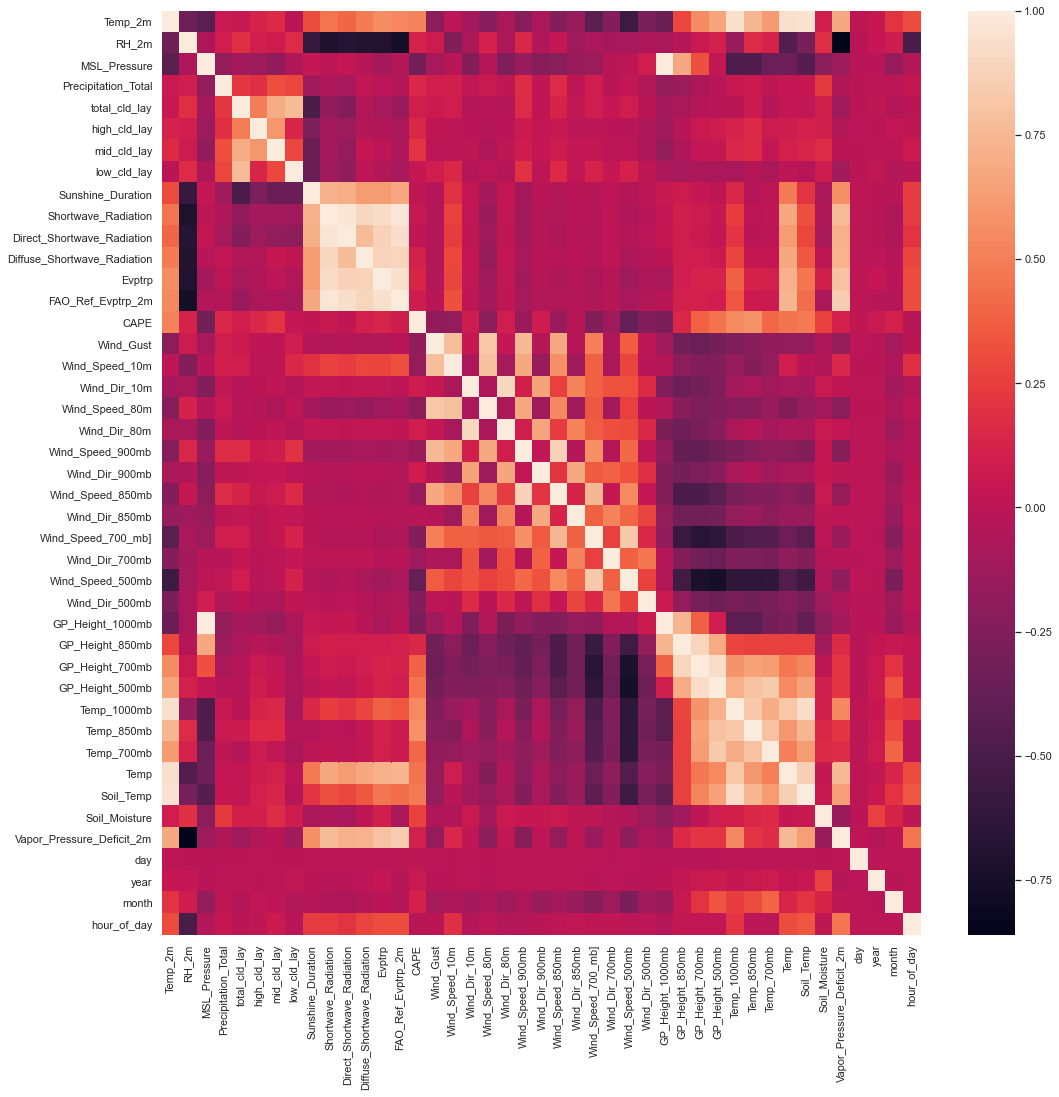

In [9]:
sns.set(rc={'figure.figsize':(17,17)})
# Calculate correlations
correlations = data.corr()
 
# Print the Correlation Heatmap using seaborn
sns.heatmap(correlations)

<H1>Creation and Analysis of Features and Targets</H1>

In [10]:
# Dividing dataset into label and feature sets
#features = data_modified.drop(['Temp_2m','RH_2m'], axis = 1) # Features
#labels = data_modified[['Temp_2m','RH_2m']] # Labels
features = data.drop(['Temp_2m','RH_2m'], axis = 1) # Features
labels = data[['Temp_2m','RH_2m']] # Labels
print(type(features))
print(type(labels))
print(features.shape)
print(labels.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(182448, 41)
(182448, 2)


In [11]:
# feature importance estimation to see which features can help in better training of the model. 
feature_importance = DecisionTreeRegressor()
feature_importance.fit(features,labels)
print(feature_importance.feature_importances_)
for feat, importance in zip(features.columns, feature_importance.feature_importances_):
    print ('feature: {f}, importance: {i}'.format(f=feat, i=importance))

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.032 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.123 0.008 0.    0.041 0.001 0.
 0.791 0.    0.    0.001 0.   ]
feature: MSL_Pressure, importance: 5.5231295900321884e-05
feature: Precipitation_Total, importance: 4.662070023212253e-06
feature: total_cld_lay, importance: 2.1127048263075034e-05
feature: high_cld_lay, importance: 1.66109696407342e-05
feature: mid_cld_lay, importance: 9.12491191273899e-06
feature: low_cld_lay, importance: 4.47823028169201e-05
feature: Sunshine_Duration, importance: 4.563206093247025e-05
feature: Shortwave_Radiation, importance: 6.237954484647543e-05
feature: Direct_Shortwave_Radiation, importance: 8.07086811603717e-05
feature: Diffuse_Shortwave_Radiation, importance: 5.6296968104180186e-05
feature: Evptrp, importance: 6.940415520347879e-05
feature: FAO_Ref_Evptrp_2m, importance: 0.0003347649455942485
feature: CAPE, importance: 0.

In [12]:
#split the data for training and testing
trainf,testf,trainl,testl=train_test_split(features,labels, test_size=0.15, random_state=22)
print(len(trainf))
print(len(trainl))
print(len(testf))
print(len(testl))
print("trainf:", trainf.shape, "trianl:", trainl.shape)
print("testf:", testf.shape, "testl:", testl.shape)

#Conver the pandas dataframes into arrays for train and test features
trainf_array = trainf.to_numpy()
trainl_array = trainl.to_numpy()
testf_array = testf.to_numpy()
testl_array = testl.to_numpy()
print("trainf_array:", trainf_array.shape, "trianl_array:", trainl_array.shape)
print("testf_array:", testf_array.shape, "testl_array:", testl_array.shape)

155080
155080
27368
27368
trainf: (155080, 41) trianl: (155080, 2)
testf: (27368, 41) testl: (27368, 2)
trainf_array: (155080, 41) trianl_array: (155080, 2)
testf_array: (27368, 41) testl_array: (27368, 2)


In [13]:
#Apply normalization on the training and testing feature sets 
scaler = StandardScaler()
# transform data
trainf_array_scaled = scaler.fit_transform(trainf_array)
testf_array_scaled = scaler.fit_transform(testf_array)


<H1> Linear Regression </H1>

In [14]:
set_config(print_changed_only=False)
model_LR = LinearRegression(normalize=True)


In [15]:
model_LR.fit(trainf_array,trainl_array)
LRpred = model_LR.predict(testf_array)
print(r2_score(LRpred, testl_array))

0.9575483230709314


### The R2 accuracy is very high which means the features and targets are linearly dependent. 

In [16]:
#Model Evaluation

mse_temp = mean_squared_error(testl_array[:,0], LRpred[:,0])
print("Mean Squared Error for Temperature is : ", mse_temp)

mse_humidity = mean_squared_error(testl_array[:,1], LRpred[:,1])
print(" Mean Squared Error for Relative Humidity is : ", mse_humidity)

rmse_temp = math.sqrt(mean_squared_error(testl_array[:,0], LRpred[:,0]))
print("Root Mean Squared Error for Temperature is : ", rmse_temp)

rmse_humidity = math.sqrt(mean_squared_error(testl_array[:,1], LRpred[:,1]))
print("Root Mean Squared Error for Relative Humidity is : ", rmse_humidity)

exp_var_score_temp = explained_variance_score(testl_array[:,0], LRpred[:,0])
print("The Explained variance score Temperature is {}".format(exp_var_score_temp))

exp_var_score_humidity = explained_variance_score(testl_array[:,1], LRpred[:,1])
print("The Explained variance score in terms of Relative Humidity is {}".format(exp_var_score_humidity))

mae_temp = mean_absolute_error(testl_array[:,0], LRpred[:,0])
print("Explained Variance Score for Temperature is ", mae_temp)

mae_hum = mean_absolute_error(testl_array[:,1], LRpred[:,1])
print("Explained Variance Score for Relative Humidity is ", mae_hum)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100

mean_abs_perc_error_temp = mean_absolute_percentage_error(testl_array[:,0], LRpred[:,0])
print("The mean absolute percentage error for Temperature is" ,mean_abs_perc_error_temp)

mean_abs_perc_error_humidity = mean_absolute_percentage_error(testl_array[:,1], LRpred[:,1])
print("The mean absolute percentage error for Relative Humidity is" ,mean_abs_perc_error_humidity)

Mean Squared Error for Temperature is :  0.2053901206852193
 Mean Squared Error for Relative Humidity is :  23.611172413791728
Root Mean Squared Error for Temperature is :  0.4531998683640798
Root Mean Squared Error for Relative Humidity is :  4.85913288702745
The Explained variance score Temperature is 0.9948201836109379
The Explained variance score in terms of Relative Humidity is 0.9259200468779117
Explained Variance Score for Temperature is  0.3312862931946686
Explained Variance Score for Relative Humidity is  3.348559790511139
The mean absolute percentage error for Temperature is 3.2971421473688083
The mean absolute percentage error for Relative Humidity is 5.456512698160341


In [17]:
#Create a pandas dataframe to store the metrics of different models performed. 
ModelMetrics = pd.DataFrame()
ModelMetrics= ModelMetrics.append([['Linear Regression',mse_temp,mse_humidity,rmse_temp,rmse_humidity,exp_var_score_temp,exp_var_score_humidity,mae_temp,mae_hum,mean_abs_perc_error_temp,mean_abs_perc_error_humidity]])
#ModelMetrics.columns= ['ModelName','MSE-Temp','MSE-RH','RMSE-Temp','RMSE-RH','R2Score-Temp','R2Score-RH','MAE-Temp','MAE-RH','MAPE-Temp','MAPE-RH']

In [18]:
ModelMetrics

0     1      2     3     4     5     6     7     8    9   \
0  Linear Regression  0.21  23.61  0.45  4.86  0.99  0.93  0.33  3.35  3.3   

     10  
0  5.46

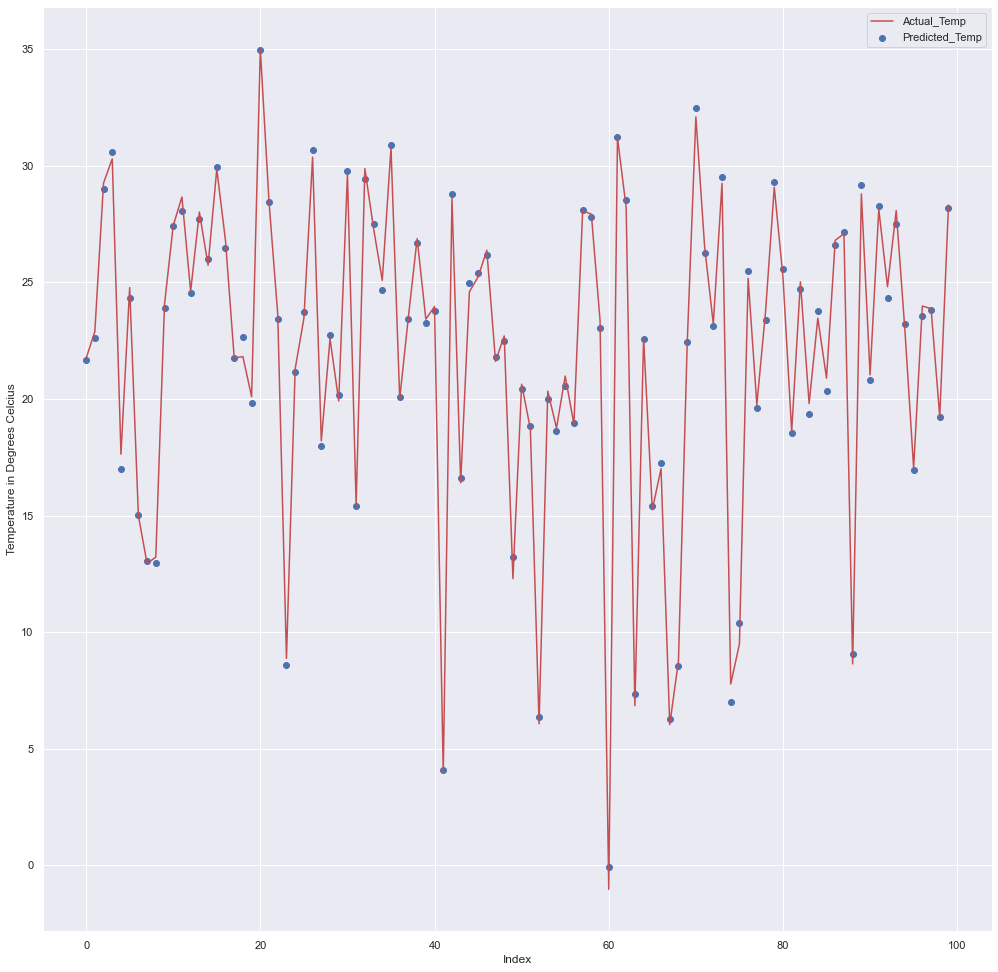

In [19]:
#Temperature Prediction
plt.plot(range(0,100), testl_array[0:100,0], label="Actual_Temp", color='r')
plt.scatter(range(0,100), LRpred[0:100,0], label="Predicted_Temp", color='b')
plt.xlabel('Index')
plt.ylabel('Temperature in Degrees Celcius')
plt.legend()
plt.show()

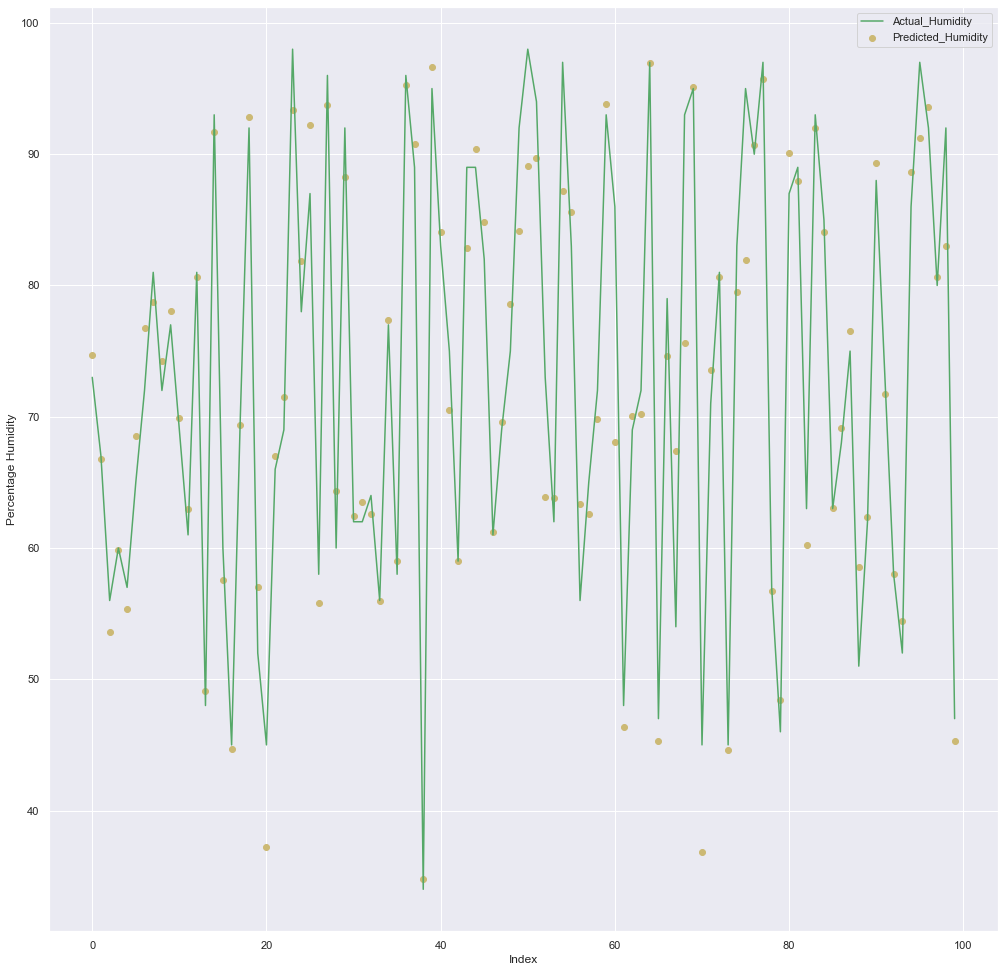

In [20]:
#Humidity Prediction
plt.plot(range(0,100), testl_array[0:100,1], label="Actual_Humidity", color='g')
plt.scatter(range(0,100), LRpred[0:100,1], label="Predicted_Humidity", color='y')
plt.xlabel('Index')
plt.ylabel('Percentage Humidity')
plt.legend()
plt.show()

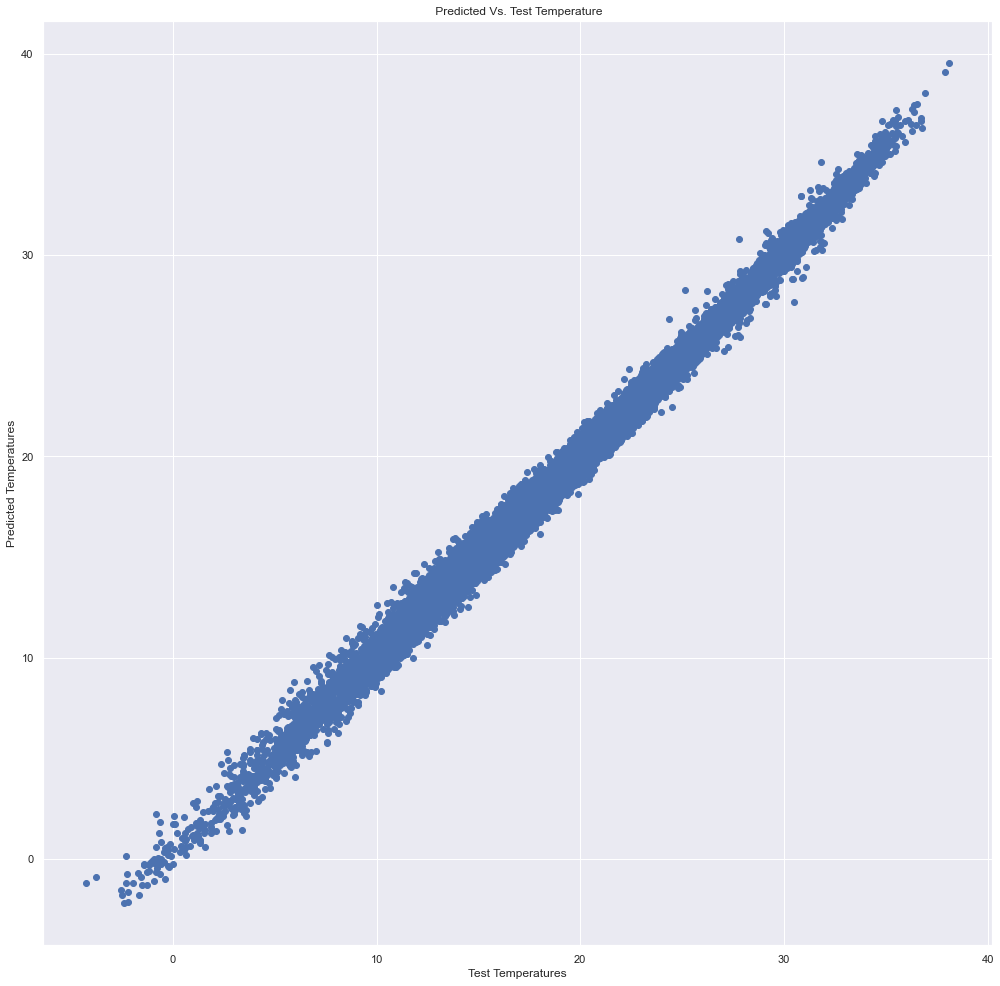

In [21]:
#Temperature Scatter Plot for predictions
plt.scatter(testl_array[:,0], LRpred[:,0])
plt.ylabel("Predicted Temperatures")
plt.xlabel("Test Temperatures")
plt.title(" Predicted Vs. Test Temperature")
plt.show()

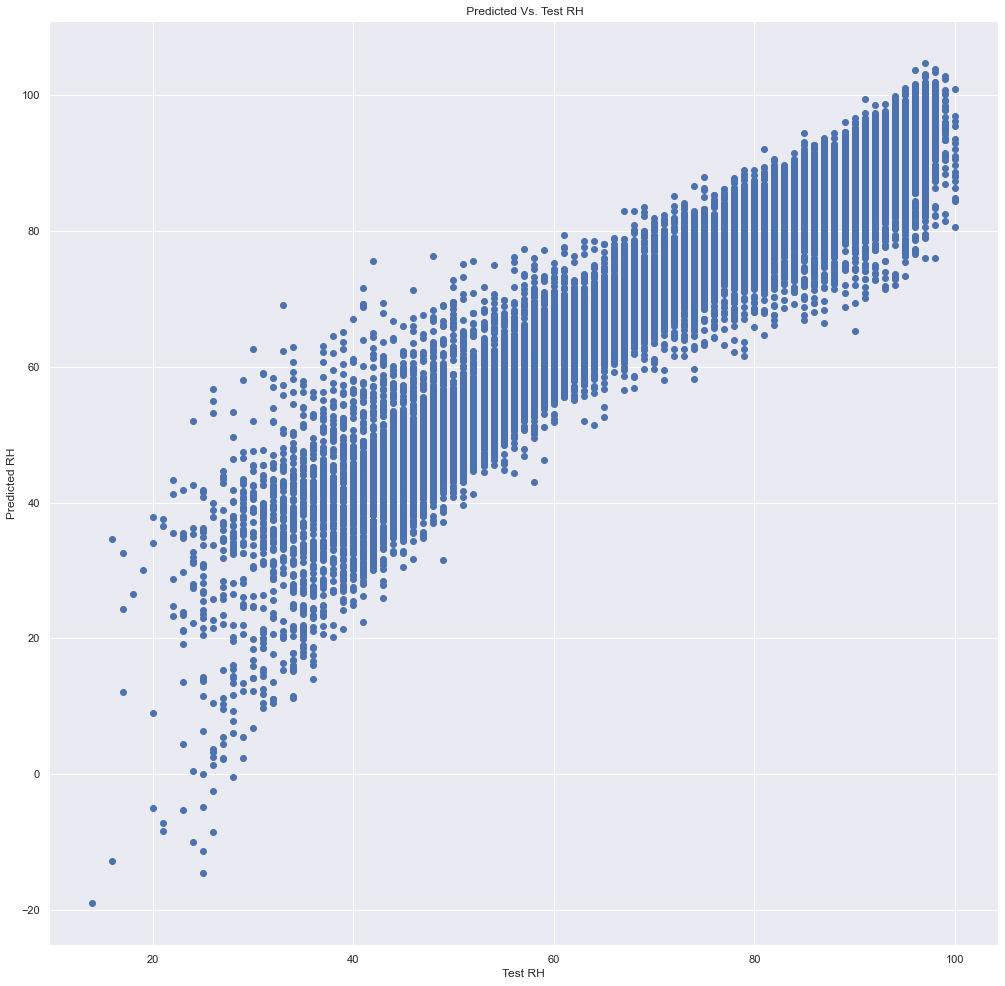

In [22]:
#RH Scatter Plot for predictions
plt.scatter(testl_array[:,1], LRpred[:,1])
plt.ylabel("Predicted RH")
plt.xlabel("Test RH")
plt.title(" Predicted Vs. Test RH")
plt.show()

<h1> KNN Regression </h1>

In [23]:
model_KNN = KNeighborsRegressor()
model_KNN.fit(trainf_array_scaled,trainl_array)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [24]:
KNNpred = model_KNN.predict(testf_array_scaled)

In [25]:
#Model Evaluation

mse_temp = mean_squared_error(testl_array[:,0], KNNpred[:,0])
print("Mean Squared Error for Temperature is : ", mse_temp)

mse_humidity = mean_squared_error(testl_array[:,1], KNNpred[:,1])
print(" Mean Squared Error for Relative Humidity is : ", mse_humidity)

rmse_temp = math.sqrt(mean_squared_error(testl_array[:,0], KNNpred[:,0]))
print("Root Mean Squared Error for Temperature is : ", rmse_temp)

rmse_humidity = math.sqrt(mean_squared_error(testl_array[:,1], KNNpred[:,1]))
print("Root Mean Squared Error for Relative Humidity is : ", rmse_humidity)

exp_var_score_temp = explained_variance_score(testl_array[:,0], KNNpred[:,0])
print("The Explained variance score Temperature is {}".format(exp_var_score_temp))

exp_var_score_humidity = explained_variance_score(testl_array[:,1], KNNpred[:,1])
print("The Explained variance score in terms of Relative Humidity is {}".format(exp_var_score_humidity))

mae_temp = mean_absolute_error(testl_array[:,0], KNNpred[:,0])
print("Explained Variance Score for Temperature is ", mae_temp)

mae_hum = mean_absolute_error(testl_array[:,1], KNNpred[:,1])
print("Explained Variance Score for Relative Humidity is ", mae_hum)

mean_abs_perc_error_temp = mean_absolute_percentage_error(testl_array[:,0], KNNpred[:,0])
print("The mean absolute percentage error for Temperature is" ,mean_abs_perc_error_temp)

mean_abs_perc_error_humidity = mean_absolute_percentage_error(testl_array[:,1], KNNpred[:,1])
print("The mean absolute percentage error for Relative Humidity is" ,mean_abs_perc_error_humidity)

Mean Squared Error for Temperature is :  0.8755923556772365
 Mean Squared Error for Relative Humidity is :  21.92111663256358
Root Mean Squared Error for Temperature is :  0.9357309205520765
Root Mean Squared Error for Relative Humidity is :  4.681999213216891
The Explained variance score Temperature is 0.9779243848328526
The Explained variance score in terms of Relative Humidity is 0.9313580480958321
Explained Variance Score for Temperature is  0.6861658010998319
Explained Variance Score for Relative Humidity is  3.3315697164571763
The mean absolute percentage error for Temperature is 5.813117037860256
The mean absolute percentage error for Relative Humidity is 5.079609244263588


In [26]:
ModelMetrics= ModelMetrics.append([['KNN Regression',mse_temp,mse_humidity,rmse_temp,rmse_humidity,exp_var_score_temp,exp_var_score_humidity,mae_temp,mae_hum,mean_abs_perc_error_temp,mean_abs_perc_error_humidity]])

In [27]:
ModelMetrics

0     1      2     3     4     5     6     7     8     9   \
0  Linear Regression  0.21  23.61  0.45  4.86  0.99  0.93  0.33  3.35  3.30   
0     KNN Regression  0.88  21.92  0.94  4.68  0.98  0.93  0.69  3.33  5.81   

     10  
0  5.46  
0  5.08

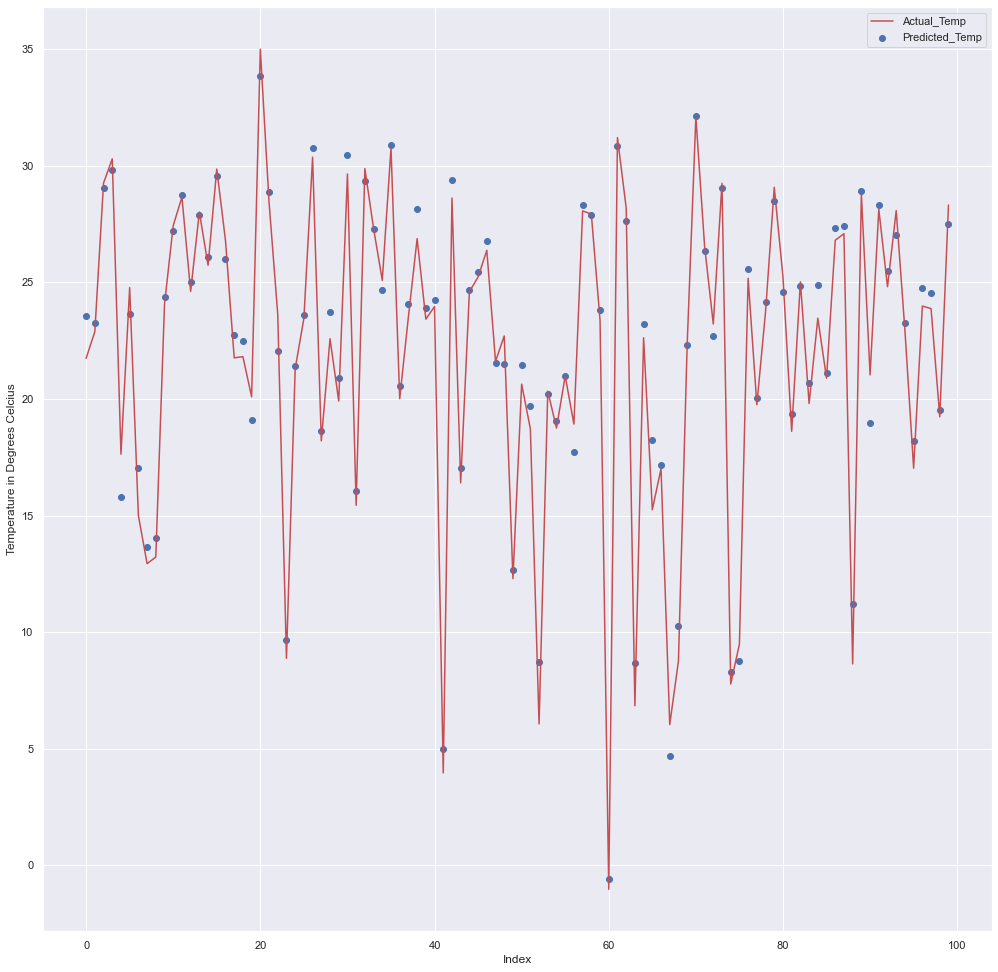

In [28]:
#Temperature Prediction
plt.plot(range(0,100), testl_array[0:100,0], label="Actual_Temp", color='r')
plt.scatter(range(0,100), KNNpred[0:100,0], label="Predicted_Temp", color='b')
plt.xlabel('Index')
plt.ylabel('Temperature in Degrees Celcius')
plt.legend()
plt.show()

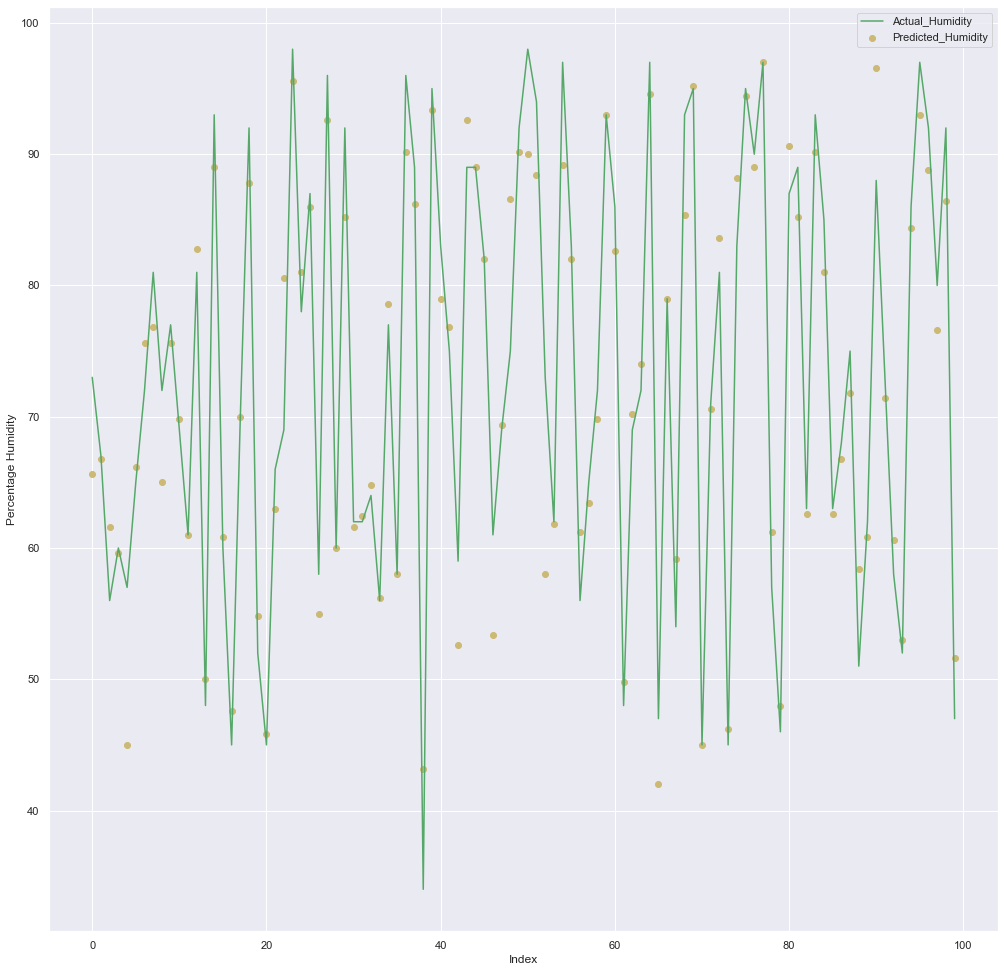

In [29]:
#RH Prediction
plt.plot(range(0,100), testl_array[0:100,1], label="Actual_Humidity", color='g')
plt.scatter(range(0,100), KNNpred[0:100,1], label="Predicted_Humidity", color='y')
plt.xlabel('Index')
plt.ylabel('Percentage Humidity')
plt.legend()
plt.show()

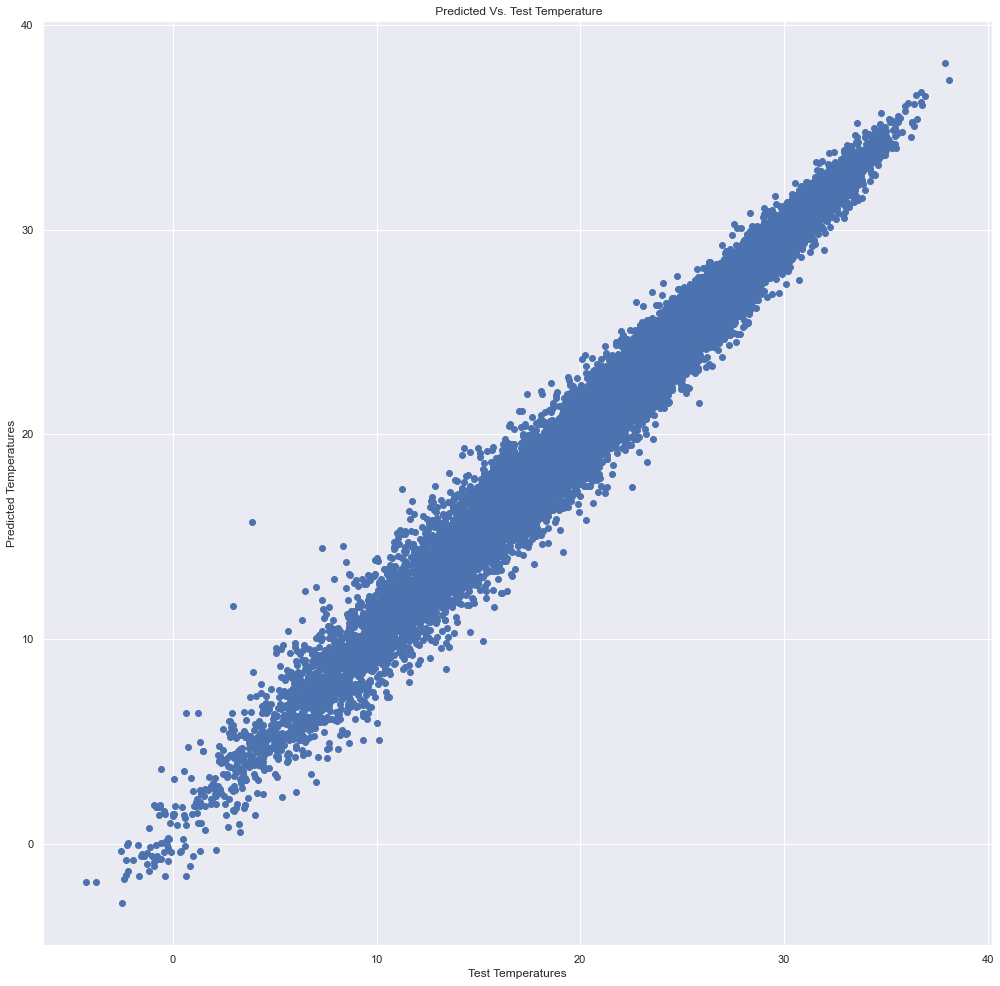

In [30]:
#Temperature Scatter Plot for predictions
plt.scatter(testl_array[:,0], KNNpred[:,0])
plt.ylabel("Predicted Temperatures")
plt.xlabel("Test Temperatures")
plt.title(" Predicted Vs. Test Temperature")
plt.show()

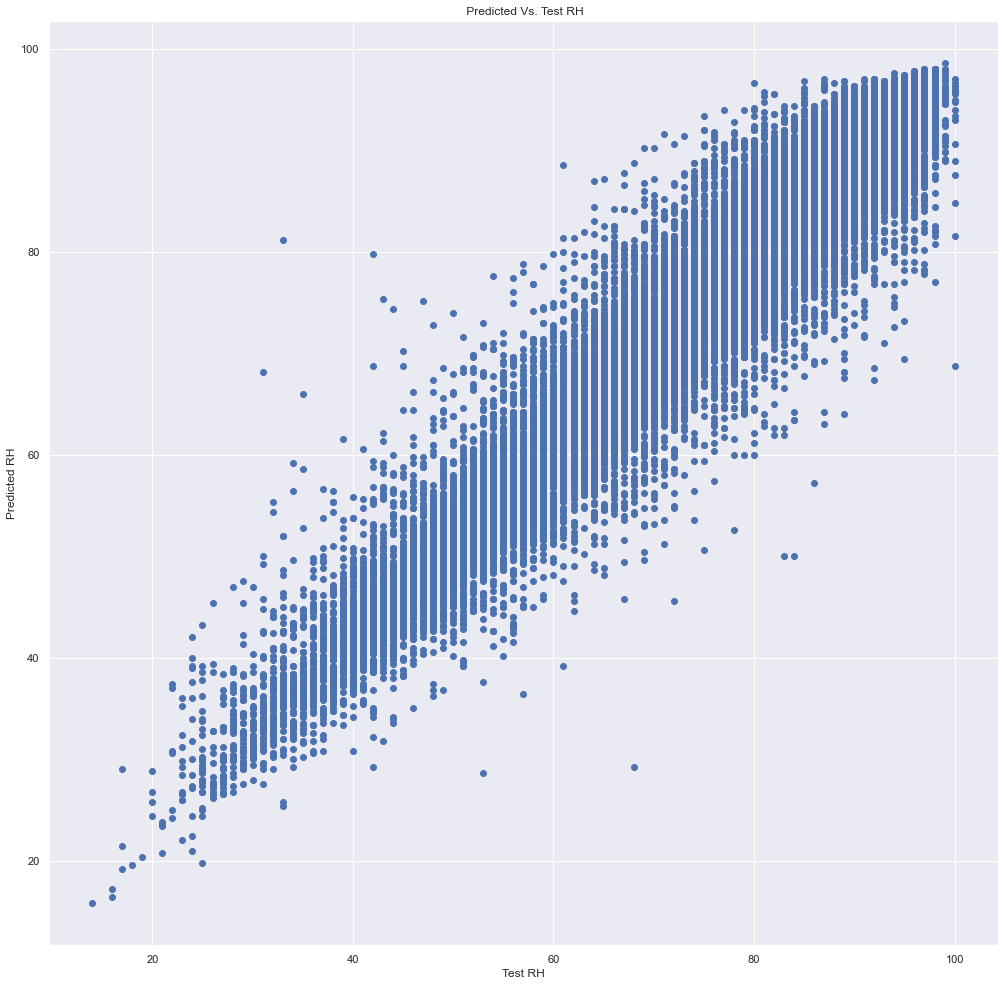

In [31]:
#RH Scatter Plot for predictions
plt.scatter(testl_array[:,1], KNNpred[:,1])
plt.ylabel("Predicted RH")
plt.xlabel("Test RH")
plt.title(" Predicted Vs. Test RH")
plt.show()

<h1> Support Vector Regression : Using Multi-Output Regressor <h1>

In [32]:
model_SVR = LinearSVR()
wrapper_SVR = MultiOutputRegressor(model_SVR)
wrapper_SVR.fit(trainf_array_scaled,trainl_array)

C:\Users\ravip\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


MultiOutputRegressor(estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                         fit_intercept=True,
                                         intercept_scaling=1.0,
                                         loss='epsilon_insensitive',
                                         max_iter=1000, random_state=None,
                                         tol=0.0001, verbose=0),
                     n_jobs=None)

In [33]:
SVRpred = wrapper_SVR.predict(testf_array_scaled)

In [34]:
#Model Evaluation

mse_temp = mean_squared_error(testl_array[:,0], SVRpred[:,0])
print("Mean Squared Error for Temperature is : ", mse_temp)

mse_humidity = mean_squared_error(testl_array[:,1], SVRpred[:,1])
print("Mean Squared Error for Relative Humidity is : ", mse_humidity)

rmse_temp = math.sqrt(mean_squared_error(testl_array[:,0], SVRpred[:,0]))
print("Root Mean Squared Error for Temperature is : ", rmse_temp)

rmse_humidity = math.sqrt(mean_squared_error(testl_array[:,1], SVRpred[:,1]))
print("Root Mean Squared Error for Relative Humidity is : ", rmse_humidity)

exp_var_score_temp = explained_variance_score(testl_array[:,0], SVRpred[:,0])
print("The Explained variance score Temperature is {}".format(exp_var_score_temp))

exp_var_score_humidity = explained_variance_score(testl_array[:,1], SVRpred[:,1])
print("The Explained variance score in terms of Relative Humidity is {}".format(exp_var_score_humidity))

mae_temp = mean_absolute_error(testl_array[:,0], SVRpred[:,0])
print("Explained Variance Score for Temperature is ", mae_temp)

mae_hum = mean_absolute_error(testl_array[:,1], SVRpred[:,1])
print("Explained Variance Score for Relative Humidity is ", mae_hum)

mean_abs_perc_error_temp = mean_absolute_percentage_error(testl_array[:,0], SVRpred[:,0])
print("The mean absolute percentage error for Temperature is" ,mean_abs_perc_error_temp)

mean_abs_perc_error_humidity = mean_absolute_percentage_error(testl_array[:,1], SVRpred[:,1])
print("The mean absolute percentage error for Relative Humidity is" ,mean_abs_perc_error_humidity)

Mean Squared Error for Temperature is :  0.2189094675387021
Mean Squared Error for Relative Humidity is :  24.60274221694099
Root Mean Squared Error for Temperature is :  0.4678776202584412
Root Mean Squared Error for Relative Humidity is :  4.960115141500345
The Explained variance score Temperature is 0.994528096472153
The Explained variance score in terms of Relative Humidity is 0.922905500783203
Explained Variance Score for Temperature is  0.32592036742754676
Explained Variance Score for Relative Humidity is  3.261678515364302
The mean absolute percentage error for Temperature is 3.6216768724946107
The mean absolute percentage error for Relative Humidity is 5.505821917297692


In [35]:
ModelMetrics= ModelMetrics.append([['SVR-Multioutput',mse_temp,mse_humidity,rmse_temp,rmse_humidity,exp_var_score_temp,exp_var_score_humidity,mae_temp,mae_hum,mean_abs_perc_error_temp,mean_abs_perc_error_humidity]])

In [36]:
ModelMetrics

0     1      2     3     4     5     6     7     8     9   \
0  Linear Regression  0.21  23.61  0.45  4.86  0.99  0.93  0.33  3.35  3.30   
0     KNN Regression  0.88  21.92  0.94  4.68  0.98  0.93  0.69  3.33  5.81   
0    SVR-Multioutput  0.22  24.60  0.47  4.96  0.99  0.92  0.33  3.26  3.62   

     10  
0  5.46  
0  5.08  
0  5.51

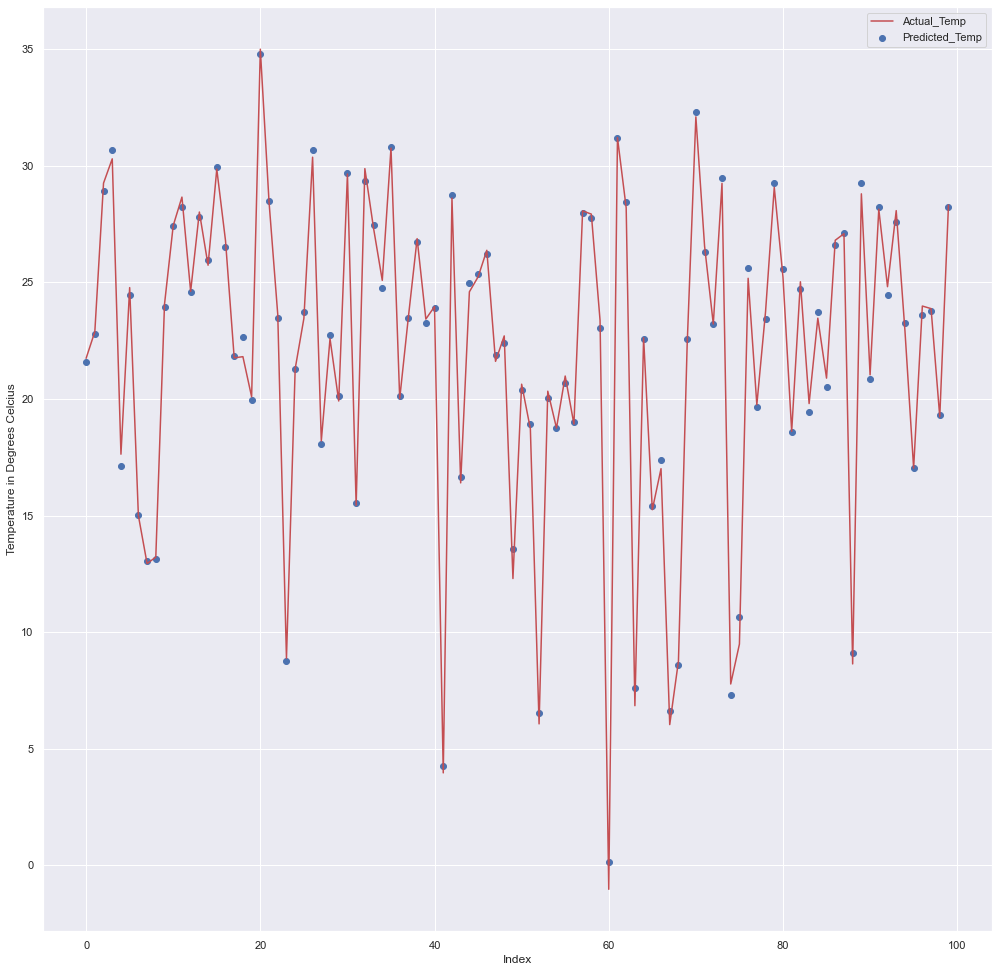

In [37]:
#Temperature Prediction
plt.plot(range(0,100), testl_array[0:100,0], label="Actual_Temp", color='r')
plt.scatter(range(0,100), SVRpred[0:100,0], label="Predicted_Temp", color='b')
plt.xlabel('Index')
plt.ylabel('Temperature in Degrees Celcius')
plt.legend()
plt.show()

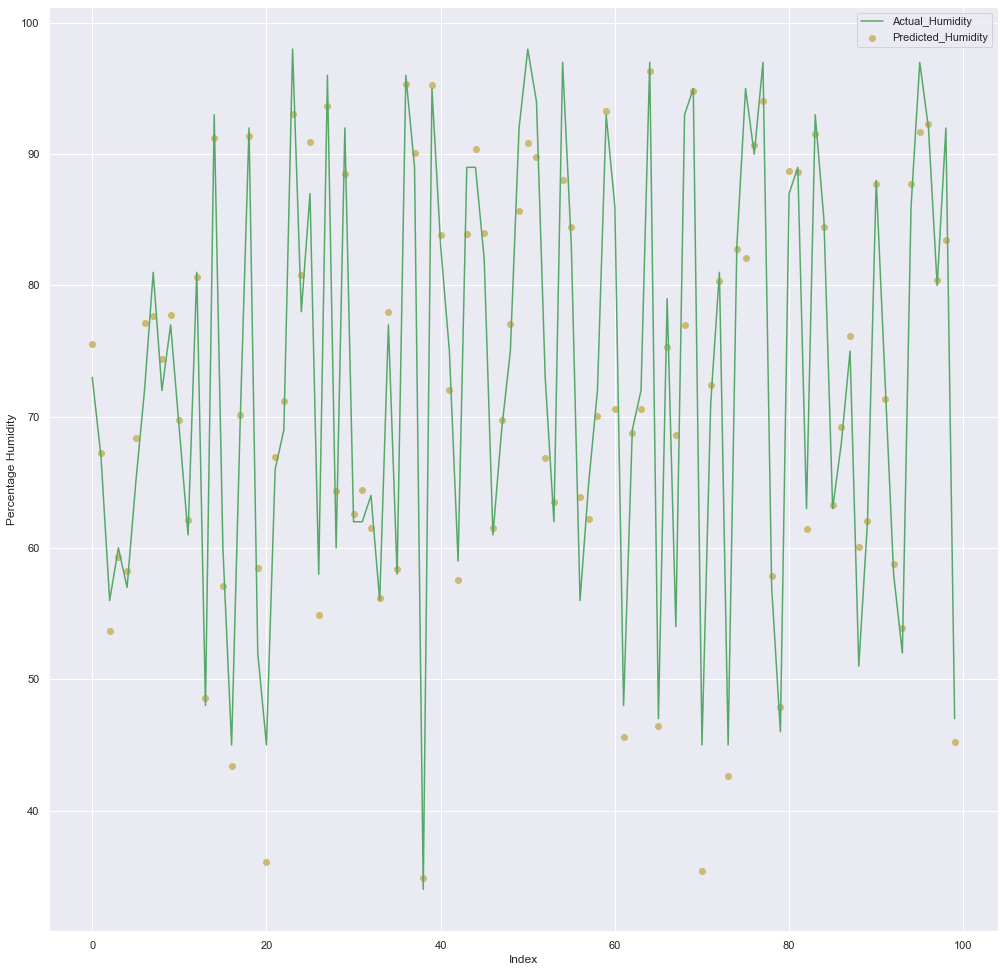

In [38]:
#RH Prediction
plt.plot(range(0,100), testl_array[0:100,1], label="Actual_Humidity", color='g')
plt.scatter(range(0,100), SVRpred[0:100,1], label="Predicted_Humidity", color='y')
plt.xlabel('Index')
plt.ylabel('Percentage Humidity')
plt.legend()
plt.show()

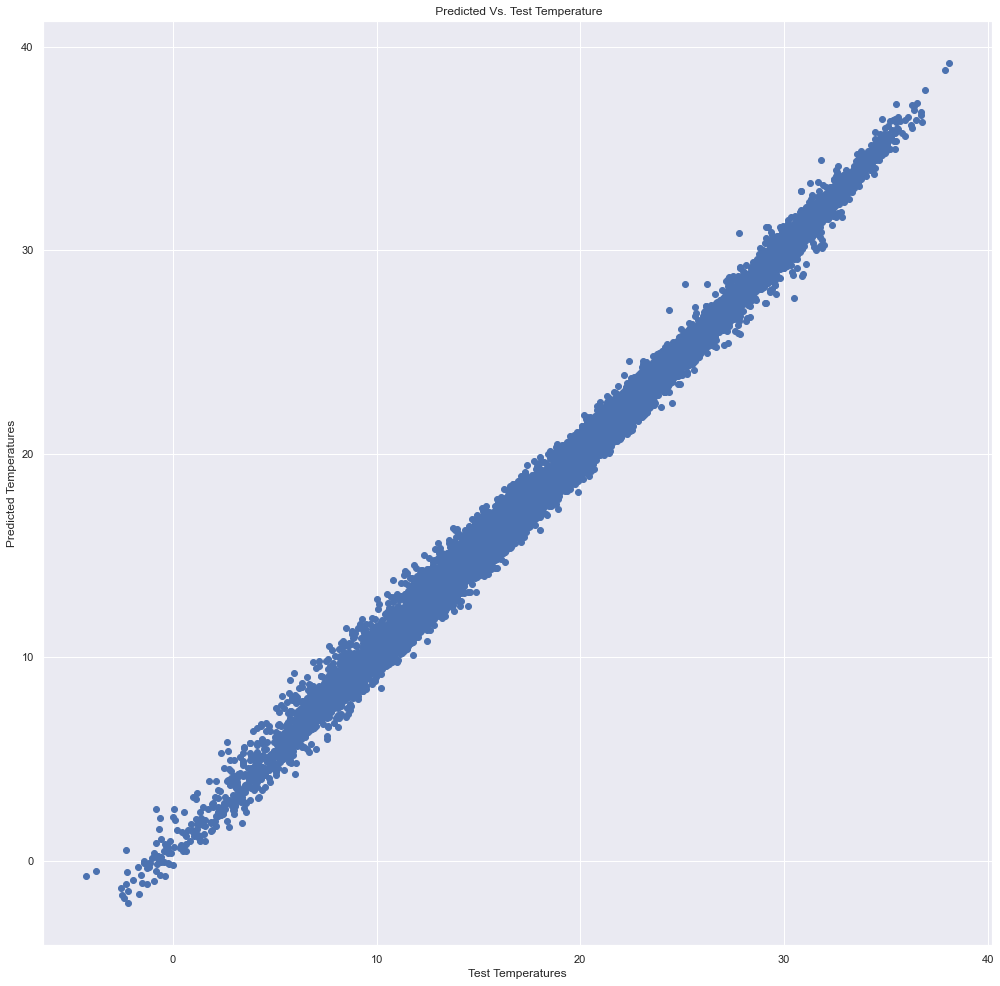

In [39]:
#Temperature Scatter Plot for predictions
plt.scatter(testl_array[:,0], SVRpred[:,0])
plt.ylabel("Predicted Temperatures")
plt.xlabel("Test Temperatures")
plt.title(" Predicted Vs. Test Temperature")
plt.show()

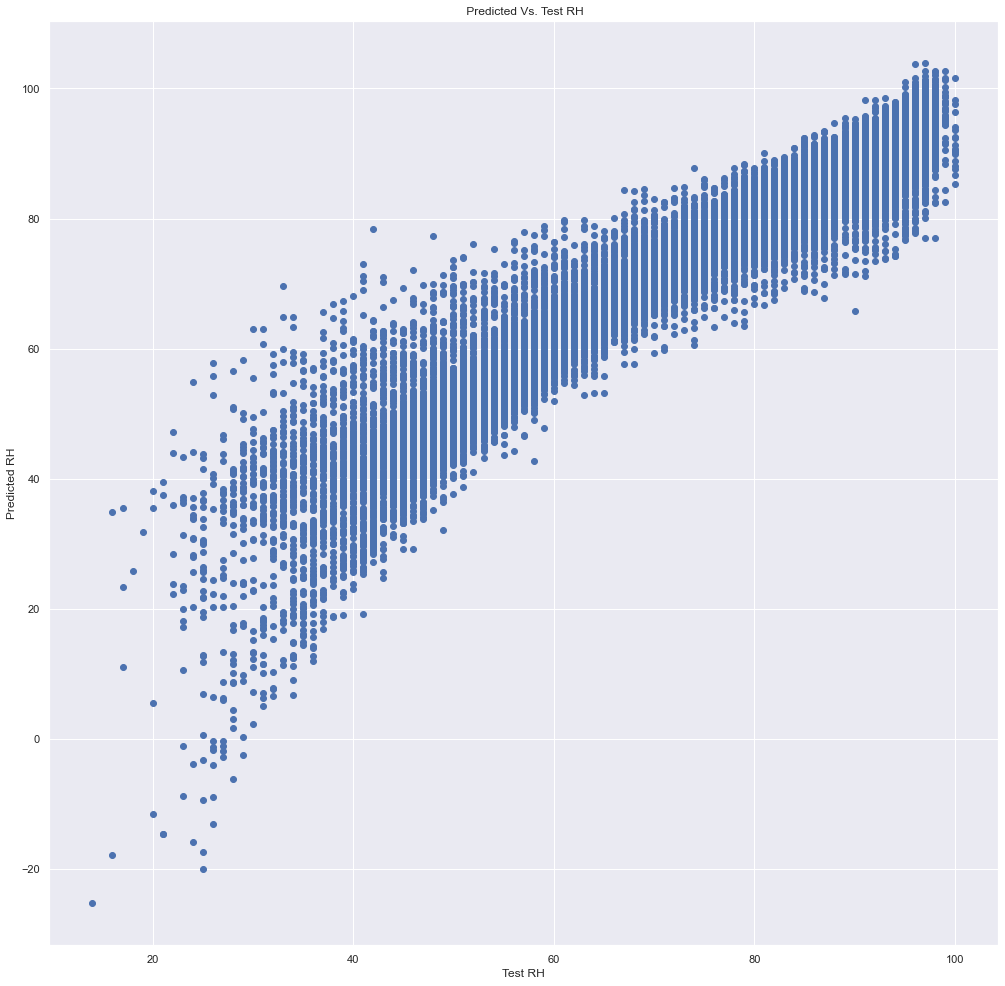

In [40]:
#RH Scatter Plot for predictions
plt.scatter(testl_array[:,1], SVRpred[:,1])
plt.ylabel("Predicted RH")
plt.xlabel("Test RH")
plt.title(" Predicted Vs. Test RH")
plt.show()

<h1>Support Vector Regression : Using Regressor Chain </h1>

In [41]:
wrapper_RCSVR=RegressorChain(model_SVR)
wrapper_RCSVR.fit(trainf_array_scaled,trainl_array)

C:\Users\ravip\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\ravip\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


RegressorChain(base_estimator=LinearSVR(C=1.0, dual=True, epsilon=0.0,
                                        fit_intercept=True,
                                        intercept_scaling=1.0,
                                        loss='epsilon_insensitive',
                                        max_iter=1000, random_state=None,
                                        tol=0.0001, verbose=0),
               cv=None, order=None, random_state=None)

In [42]:
RCSVRpred = wrapper_RCSVR.predict(testf_array_scaled)

In [43]:
#Model Evaluation

mse_temp = mean_squared_error(testl_array[:,0], RCSVRpred[:,0])
print("Mean Squared Error for Temperature is : ", mse_temp)

mse_humidity = mean_squared_error(testl_array[:,1], RCSVRpred[:,1])
print("Mean Squared Error for Relative Humidity is : ", mse_humidity)

rmse_temp = math.sqrt(mean_squared_error(testl_array[:,0], RCSVRpred[:,0]))
print("Root Mean Squared Error for Temperature is : ", rmse_temp)

rmse_humidity = math.sqrt(mean_squared_error(testl_array[:,1], RCSVRpred[:,1]))
print("Root Mean Squared Error for Relative Humidity is : ", rmse_humidity)

exp_var_score_temp = explained_variance_score(testl_array[:,0], RCSVRpred[:,0])
print("The Explained variance score Temperature is {}".format(exp_var_score_temp))

exp_var_score_humidity = explained_variance_score(testl_array[:,1], RCSVRpred[:,1])
print("The Explained variance score in terms of Relative Humidity is {}".format(exp_var_score_humidity))

mae_temp = mean_absolute_error(testl_array[:,0], RCSVRpred[:,0])
print("Explained Variance Score for Temperature is ", mae_temp)

mae_hum = mean_absolute_error(testl_array[:,1], RCSVRpred[:,1])
print("Explained Variance Score for Relative Humidity is ", mae_hum)

mean_abs_perc_error_temp = mean_absolute_percentage_error(testl_array[:,0], RCSVRpred[:,0])
print("The mean absolute percentage error for Temperature is" ,mean_abs_perc_error_temp)

mean_abs_perc_error_humidity = mean_absolute_percentage_error(testl_array[:,1], RCSVRpred[:,1])
print("The mean absolute percentage error for Relative Humidity is" ,mean_abs_perc_error_humidity)

Mean Squared Error for Temperature is :  0.22208415023602257
Mean Squared Error for Relative Humidity is :  24.45490501601221
Root Mean Squared Error for Temperature is :  0.47125805057953396
Root Mean Squared Error for Relative Humidity is :  4.945190088966471
The Explained variance score Temperature is 0.9944407899384382
The Explained variance score in terms of Relative Humidity is 0.9232686258344199
Explained Variance Score for Temperature is  0.3268544994165558
Explained Variance Score for Relative Humidity is  3.2751970535393937
The mean absolute percentage error for Temperature is 3.655108630742643
The mean absolute percentage error for Relative Humidity is 5.481402848320226


In [44]:
ModelMetrics= ModelMetrics.append([['SVR-RegressorChain',mse_temp,mse_humidity,rmse_temp,rmse_humidity,exp_var_score_temp,exp_var_score_humidity,mae_temp,mae_hum,mean_abs_perc_error_temp,mean_abs_perc_error_humidity]])

In [45]:
ModelMetrics

0     1      2     3     4     5     6     7     8     9   \
0   Linear Regression  0.21  23.61  0.45  4.86  0.99  0.93  0.33  3.35  3.30   
0      KNN Regression  0.88  21.92  0.94  4.68  0.98  0.93  0.69  3.33  5.81   
0     SVR-Multioutput  0.22  24.60  0.47  4.96  0.99  0.92  0.33  3.26  3.62   
0  SVR-RegressorChain  0.22  24.45  0.47  4.95  0.99  0.92  0.33  3.28  3.66   

     10  
0  5.46  
0  5.08  
0  5.51  
0  5.48

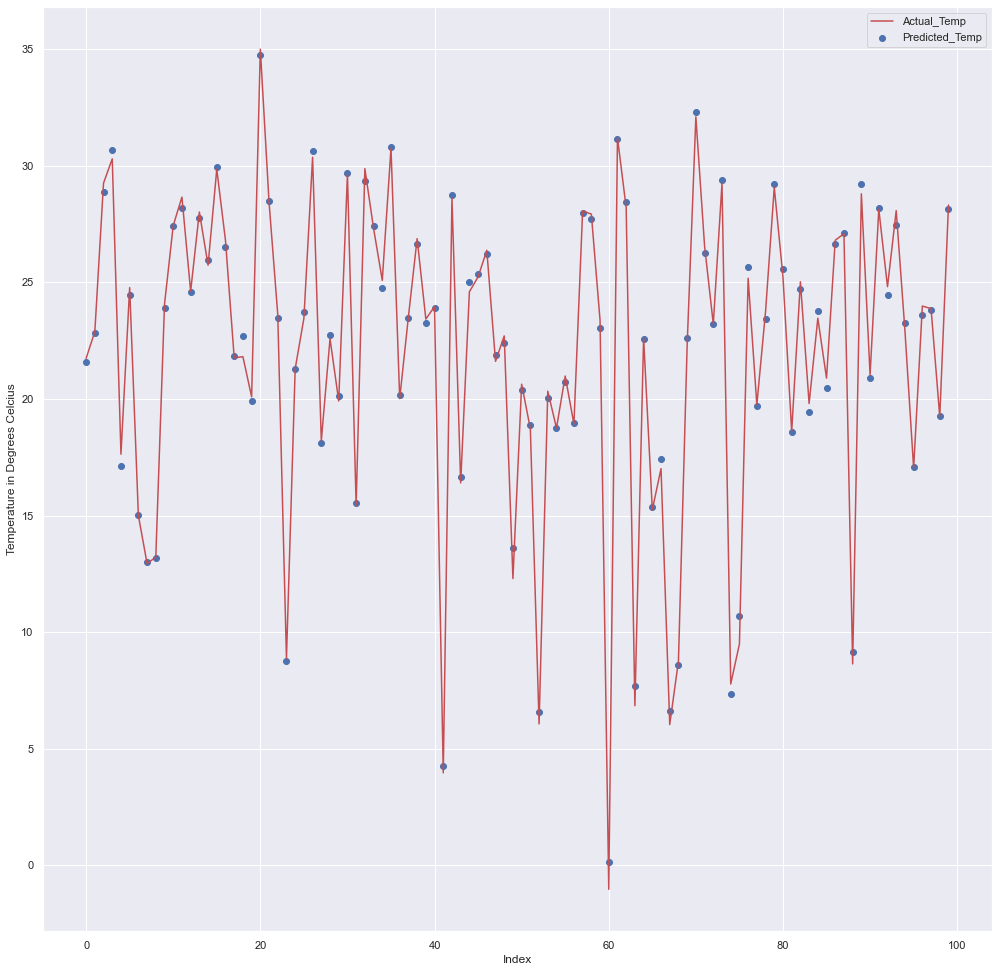

In [46]:
#Temperature Prediction
plt.plot(range(0,100), testl_array[0:100,0], label="Actual_Temp", color='r')
plt.scatter(range(0,100), RCSVRpred[0:100,0], label="Predicted_Temp", color='b')
plt.xlabel('Index')
plt.ylabel('Temperature in Degrees Celcius')
plt.legend()
plt.show()

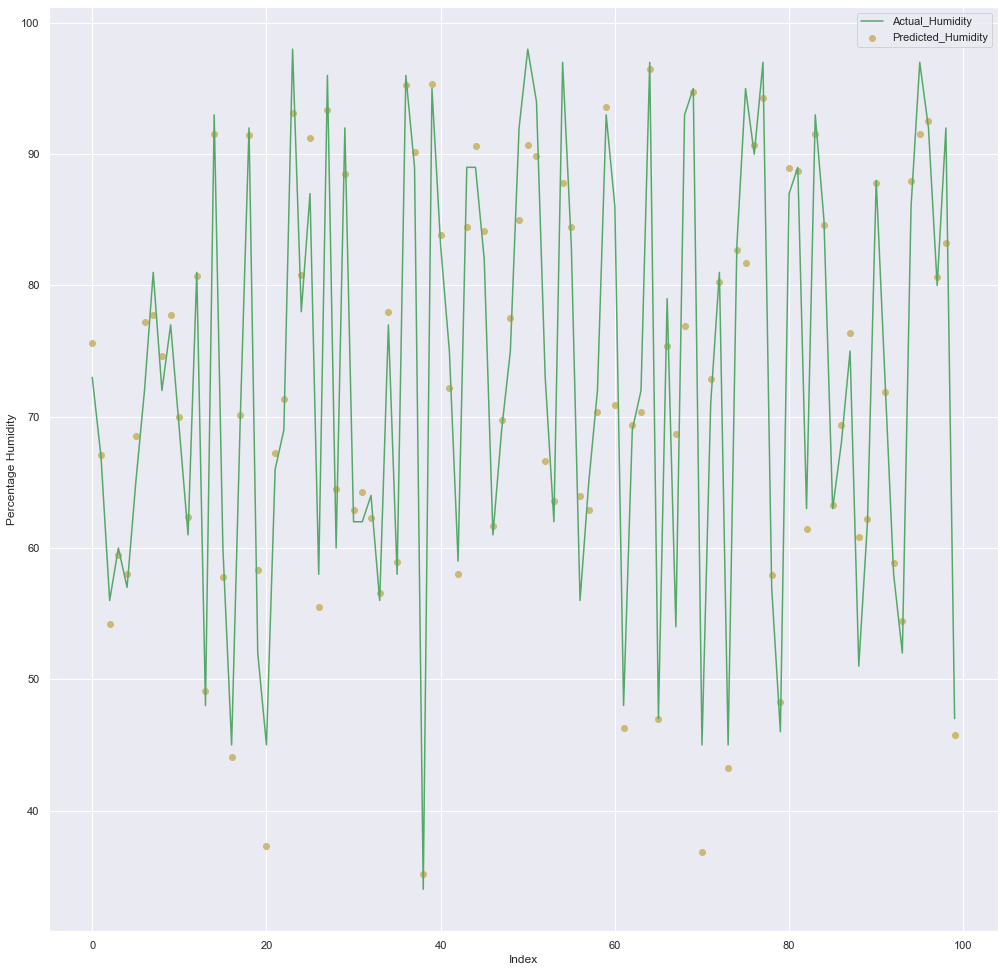

In [47]:
#RH Prediction
plt.plot(range(0,100), testl_array[0:100,1], label="Actual_Humidity", color='g')
plt.scatter(range(0,100), RCSVRpred[0:100,1], label="Predicted_Humidity", color='y')
plt.xlabel('Index')
plt.ylabel('Percentage Humidity')
plt.legend()
plt.show()

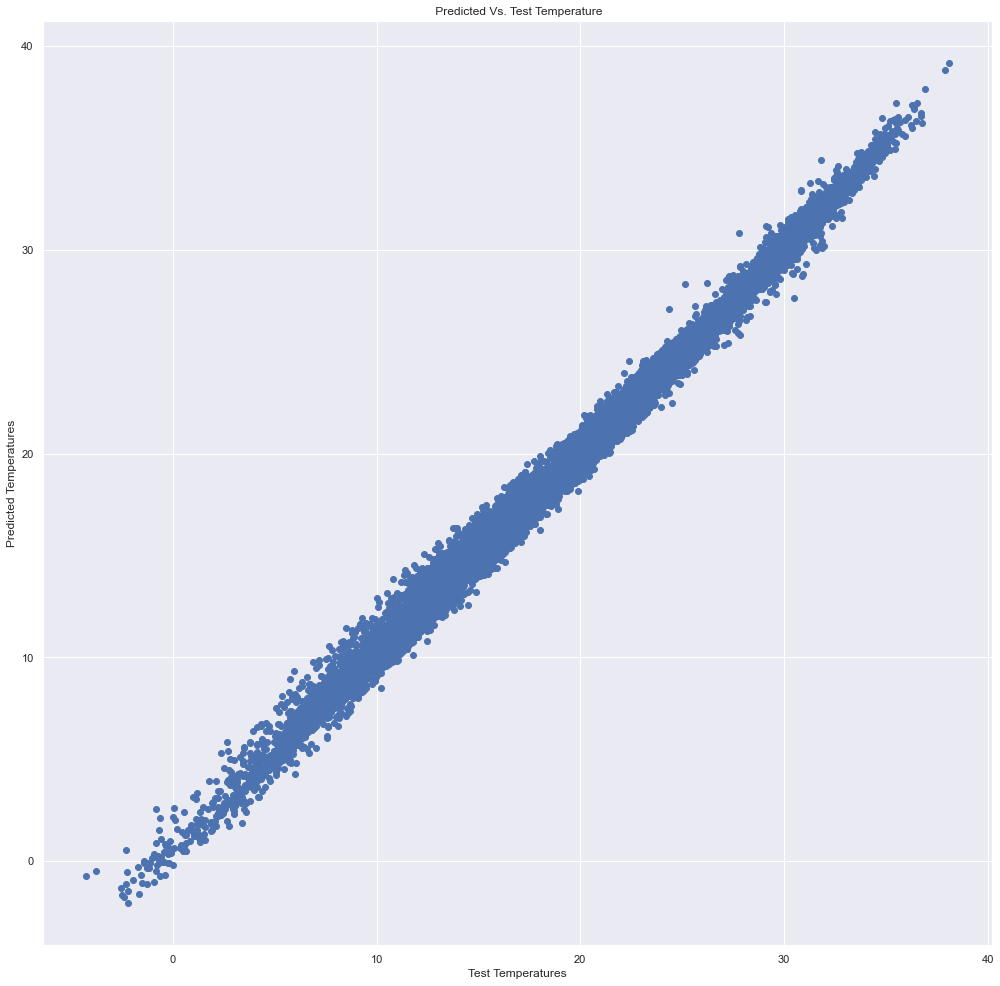

In [48]:
#Temperature Scatter Plot for predictions
plt.scatter(testl_array[:,0], RCSVRpred[:,0])
plt.ylabel("Predicted Temperatures")
plt.xlabel("Test Temperatures")
plt.title(" Predicted Vs. Test Temperature")
plt.show()

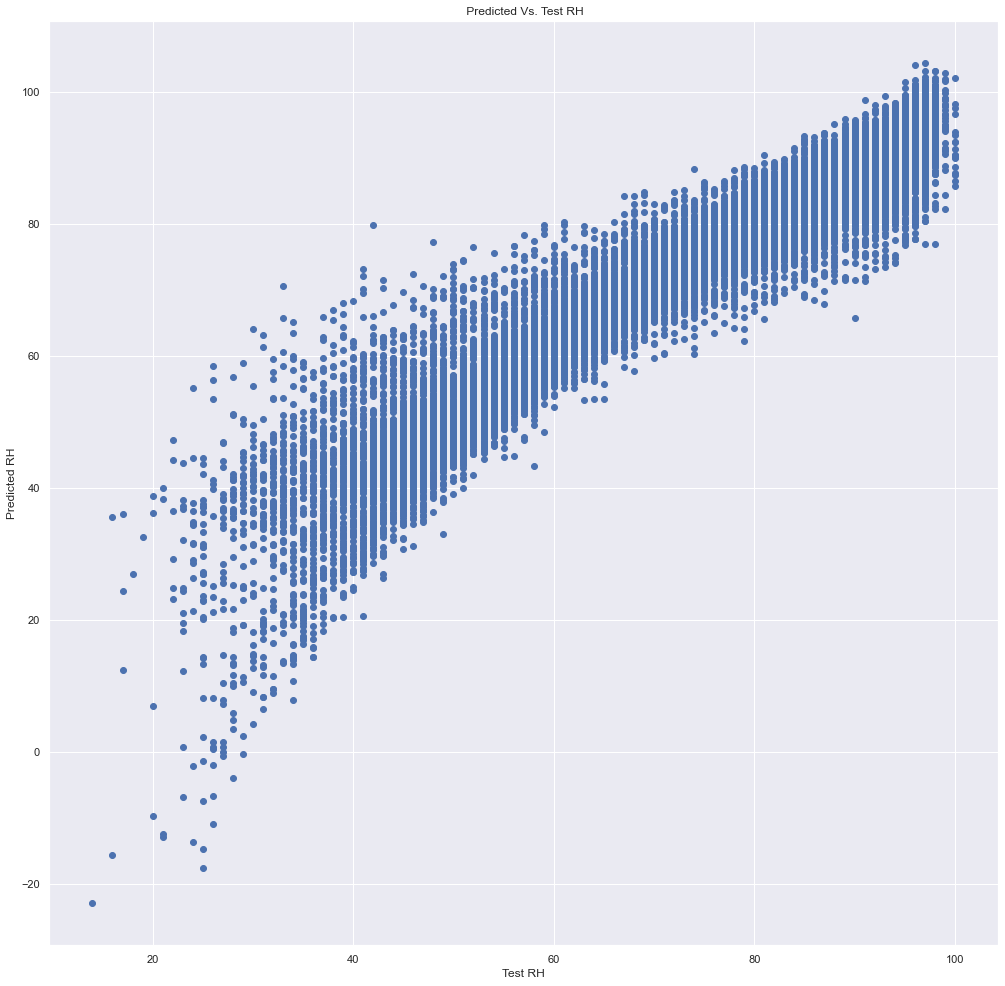

In [49]:
#RH Scatter Plot for predictions
plt.scatter(testl_array[:,1], RCSVRpred[:,1])
plt.ylabel("Predicted RH")
plt.xlabel("Test RH")
plt.title(" Predicted Vs. Test RH")
plt.show()

<h1> Decision Tree Regressor <h1>

In [50]:
model_DT = DecisionTreeRegressor()
model_DT.fit(trainf_array,trainl_array)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [51]:
DTpred = model_DT.predict(testf_array)

In [52]:
#Model Evaluation

mse_temp = mean_squared_error(testl_array[:,0], DTpred[:,0])
print("Mean Squared Error for Temperature is : ", mse_temp)

mse_humidity = mean_squared_error(testl_array[:,1], DTpred[:,1])
print("Mean Squared Error for Relative Humidity is : ", mse_humidity)

rmse_temp = math.sqrt(mean_squared_error(testl_array[:,0], DTpred[:,0]))
print("Root Mean Squared Error for Temperature is : ", rmse_temp)

rmse_humidity = math.sqrt(mean_squared_error(testl_array[:,1], DTpred[:,1]))
print("Root Mean Squared Error for Relative Humidity is : ", rmse_humidity)

exp_var_score_temp = explained_variance_score(testl_array[:,0], DTpred[:,0])
print("The Explained variance score Temperature is {}".format(exp_var_score_temp))

exp_var_score_humidity = explained_variance_score(testl_array[:,1], DTpred[:,1])
print("The Explained variance score in terms of Relative Humidity is {}".format(exp_var_score_humidity))

mae_temp = mean_absolute_error(testl_array[:,0], DTpred[:,0])
print("Explained Variance Score for Temperature is ", mae_temp)

mae_hum = mean_absolute_error(testl_array[:,1], DTpred[:,1])
print("Explained Variance Score for Relative Humidity is ", mae_hum)

mean_abs_perc_error_temp = mean_absolute_percentage_error(testl_array[:,0], DTpred[:,0])
print("The mean absolute percentage error for Temperature is" ,mean_abs_perc_error_temp)

mean_abs_perc_error_humidity = mean_absolute_percentage_error(testl_array[:,1], DTpred[:,1])
print("The mean absolute percentage error for Relative Humidity is" ,mean_abs_perc_error_humidity)

Mean Squared Error for Temperature is :  0.33148351902165396
Mean Squared Error for Relative Humidity is :  1.6055612394036831
Root Mean Squared Error for Temperature is :  0.5757460542823146
Root Mean Squared Error for Relative Humidity is :  1.2671074300956817
The Explained variance score Temperature is 0.9916401539626866
The Explained variance score in terms of Relative Humidity is 0.9949622231340097
Explained Variance Score for Temperature is  0.34422060370925894
Explained Variance Score for Relative Humidity is  0.6658506284712072
The mean absolute percentage error for Temperature is 2.9758944340100633
The mean absolute percentage error for Relative Humidity is 1.2145903615166869


In [53]:
ModelMetrics= ModelMetrics.append([['Decison Tree Regressor',mse_temp,mse_humidity,rmse_temp,rmse_humidity,exp_var_score_temp,exp_var_score_humidity,mae_temp,mae_hum,mean_abs_perc_error_temp,mean_abs_perc_error_humidity]])

In [54]:
ModelMetrics

0     1      2     3     4     5     6     7     8   \
0       Linear Regression  0.21  23.61  0.45  4.86  0.99  0.93  0.33  3.35   
0          KNN Regression  0.88  21.92  0.94  4.68  0.98  0.93  0.69  3.33   
0         SVR-Multioutput  0.22  24.60  0.47  4.96  0.99  0.92  0.33  3.26   
0      SVR-RegressorChain  0.22  24.45  0.47  4.95  0.99  0.92  0.33  3.28   
0  Decison Tree Regressor  0.33   1.61  0.58  1.27  0.99  0.99  0.34  0.67   

     9     10  
0  3.30  5.46  
0  5.81  5.08  
0  3.62  5.51  
0  3.66  5.48  
0  2.98  1.21

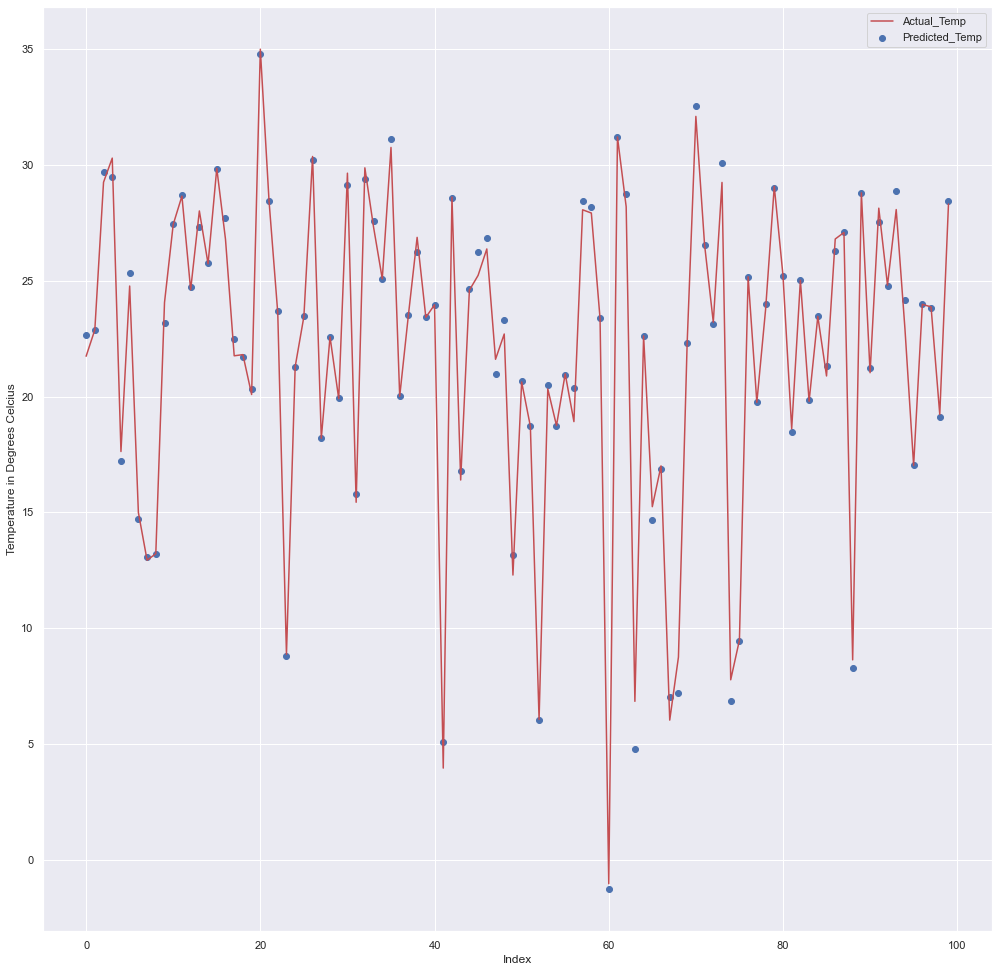

In [55]:
#Temperature Prediction
plt.plot(range(0,100), testl_array[0:100,0], label="Actual_Temp", color='r')
plt.scatter(range(0,100), DTpred[0:100,0], label="Predicted_Temp", color='b')
plt.xlabel('Index')
plt.ylabel('Temperature in Degrees Celcius')
plt.legend()
plt.show()

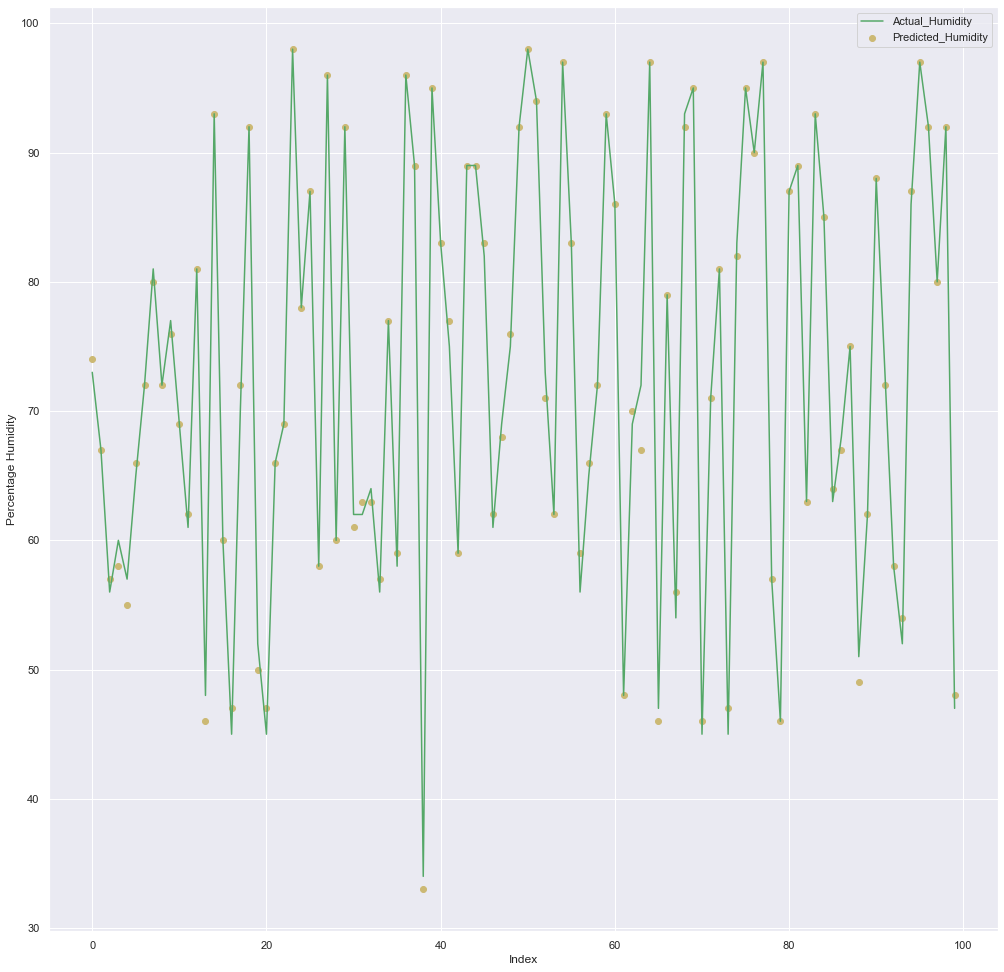

In [56]:
#RH Prediction
plt.plot(range(0,100), testl_array[0:100,1], label="Actual_Humidity", color='g')
plt.scatter(range(0,100), DTpred[0:100,1], label="Predicted_Humidity", color='y')
plt.xlabel('Index')
plt.ylabel('Percentage Humidity')
plt.legend()
plt.show()

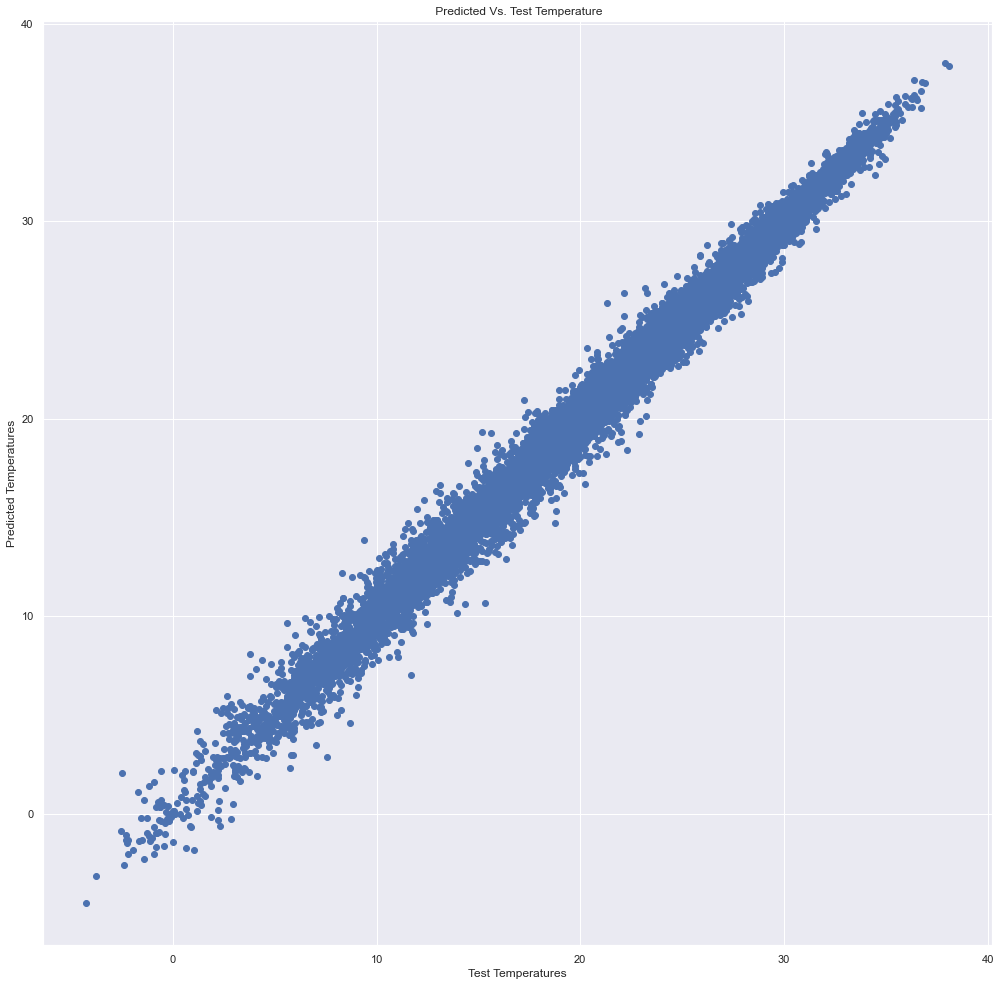

In [57]:
#Temperature Scatter Plot for predictions
plt.scatter(testl_array[:,0], DTpred[:,0])
plt.ylabel("Predicted Temperatures")
plt.xlabel("Test Temperatures")
plt.title(" Predicted Vs. Test Temperature")
plt.show()

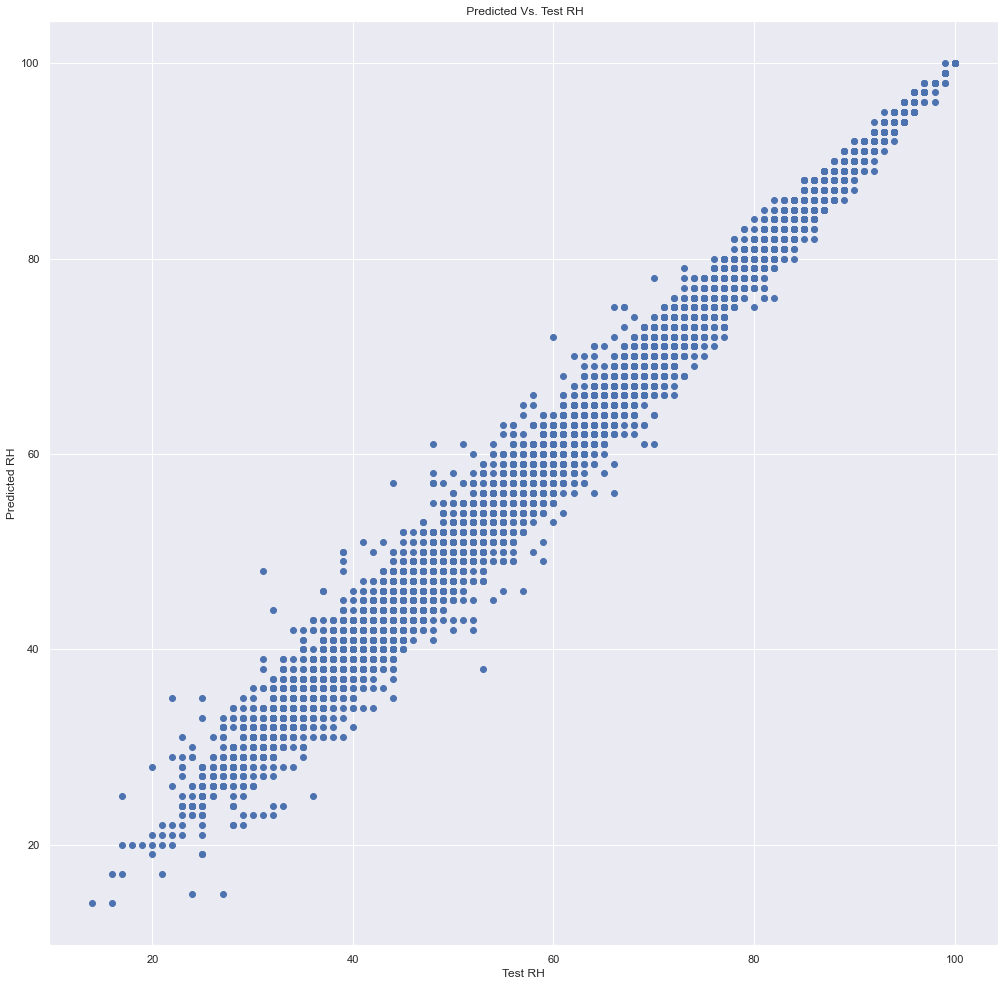

In [58]:
#RH Scatter Plot for predictions
plt.scatter(testl_array[:,1], DTpred[:,1])
plt.ylabel("Predicted RH")
plt.xlabel("Test RH")
plt.title(" Predicted Vs. Test RH")
plt.show()

<h1> Gradient Boosted Trees - Scikit Learn </h1>

In [59]:
gbr = GradientBoostingRegressor()
model_gbr = MultiOutputRegressor(estimator=gbr)
model_gbr.fit(trainf_array_scaled,trainl_array)

MultiOutputRegressor(estimator=GradientBoostingRegressor(alpha=0.9,
                                                         ccp_alpha=0.0,
                                                         criterion='friedman_mse',
                                                         init=None,
                                                         learning_rate=0.1,
                                                         loss='ls', max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_

In [60]:
GBRpred=model_gbr.predict(testf_array_scaled)

In [61]:
#Model Evaluation

mse_temp = mean_squared_error(testl_array[:,0], GBRpred[:,0])
print("Mean Squared Error for Temperature is : ", mse_temp)

mse_humidity = mean_squared_error(testl_array[:,1], GBRpred[:,1])
print("Mean Squared Error for Relative Humidity is : ", mse_humidity)

rmse_temp = math.sqrt(mean_squared_error(testl_array[:,0], GBRpred[:,0]))
print("Root Mean Squared Error for Temperature is : ", rmse_temp)

rmse_humidity = math.sqrt(mean_squared_error(testl_array[:,1], GBRpred[:,1]))
print("Root Mean Squared Error for Relative Humidity is : ", rmse_humidity)

exp_var_score_temp = explained_variance_score(testl_array[:,0], GBRpred[:,0])
print("The Explained variance score Temperature is {}".format(exp_var_score_temp))

exp_var_score_humidity = explained_variance_score(testl_array[:,1], GBRpred[:,1])
print("The Explained variance score in terms of Relative Humidity is {}".format(exp_var_score_humidity))

mae_temp = mean_absolute_error(testl_array[:,0], GBRpred[:,0])
print("Explained Variance Score for Temperature is ", mae_temp)

mae_hum = mean_absolute_error(testl_array[:,1], GBRpred[:,1])
print("Explained Variance Score for Relative Humidity is ", mae_hum)

mean_abs_perc_error_temp = mean_absolute_percentage_error(testl_array[:,0], GBRpred[:,0])
print("The mean absolute percentage error for Temperature is" ,mean_abs_perc_error_temp)

mean_abs_perc_error_humidity = mean_absolute_percentage_error(testl_array[:,1], GBRpred[:,1])
print("The mean absolute percentage error for Relative Humidity is" ,mean_abs_perc_error_humidity)

Mean Squared Error for Temperature is :  0.1708454245868047
Mean Squared Error for Relative Humidity is :  2.934639318517784
Root Mean Squared Error for Temperature is :  0.4133345189877138
Root Mean Squared Error for Relative Humidity is :  1.7130789002605176
The Explained variance score Temperature is 0.9956922175656114
The Explained variance score in terms of Relative Humidity is 0.990802724069702
Explained Variance Score for Temperature is  0.29706159344592403
Explained Variance Score for Relative Humidity is  1.1105368710712231
The mean absolute percentage error for Temperature is 2.995174581944875
The mean absolute percentage error for Relative Humidity is 1.9567315055374888


In [62]:
ModelMetrics= ModelMetrics.append([['Gradient Boosted Trees',mse_temp,mse_humidity,rmse_temp,rmse_humidity,exp_var_score_temp,exp_var_score_humidity,mae_temp,mae_hum,mean_abs_perc_error_temp,mean_abs_perc_error_humidity]])

In [63]:
ModelMetrics

0     1      2     3     4     5     6     7     8   \
0       Linear Regression  0.21  23.61  0.45  4.86  0.99  0.93  0.33  3.35   
0          KNN Regression  0.88  21.92  0.94  4.68  0.98  0.93  0.69  3.33   
0         SVR-Multioutput  0.22  24.60  0.47  4.96  0.99  0.92  0.33  3.26   
0      SVR-RegressorChain  0.22  24.45  0.47  4.95  0.99  0.92  0.33  3.28   
0  Decison Tree Regressor  0.33   1.61  0.58  1.27  0.99  0.99  0.34  0.67   
0  Gradient Boosted Trees  0.17   2.93  0.41  1.71  1.00  0.99  0.30  1.11   

     9     10  
0  3.30  5.46  
0  5.81  5.08  
0  3.62  5.51  
0  3.66  5.48  
0  2.98  1.21  
0  3.00  1.96

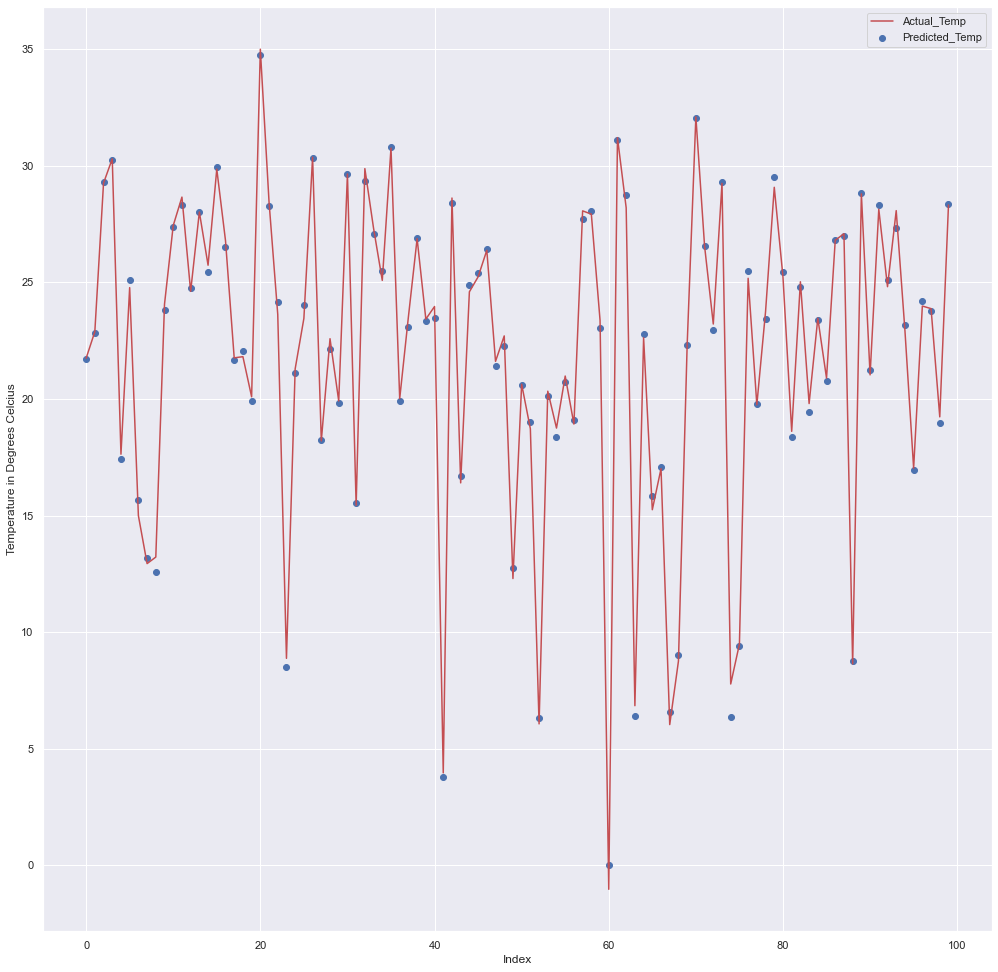

In [64]:
#Temperature Prediction
plt.plot(range(0,100), testl_array[0:100,0], label="Actual_Temp", color='r')
plt.scatter(range(0,100), GBRpred[0:100,0], label="Predicted_Temp", color='b')
plt.xlabel('Index')
plt.ylabel('Temperature in Degrees Celcius')
plt.legend()
plt.show()

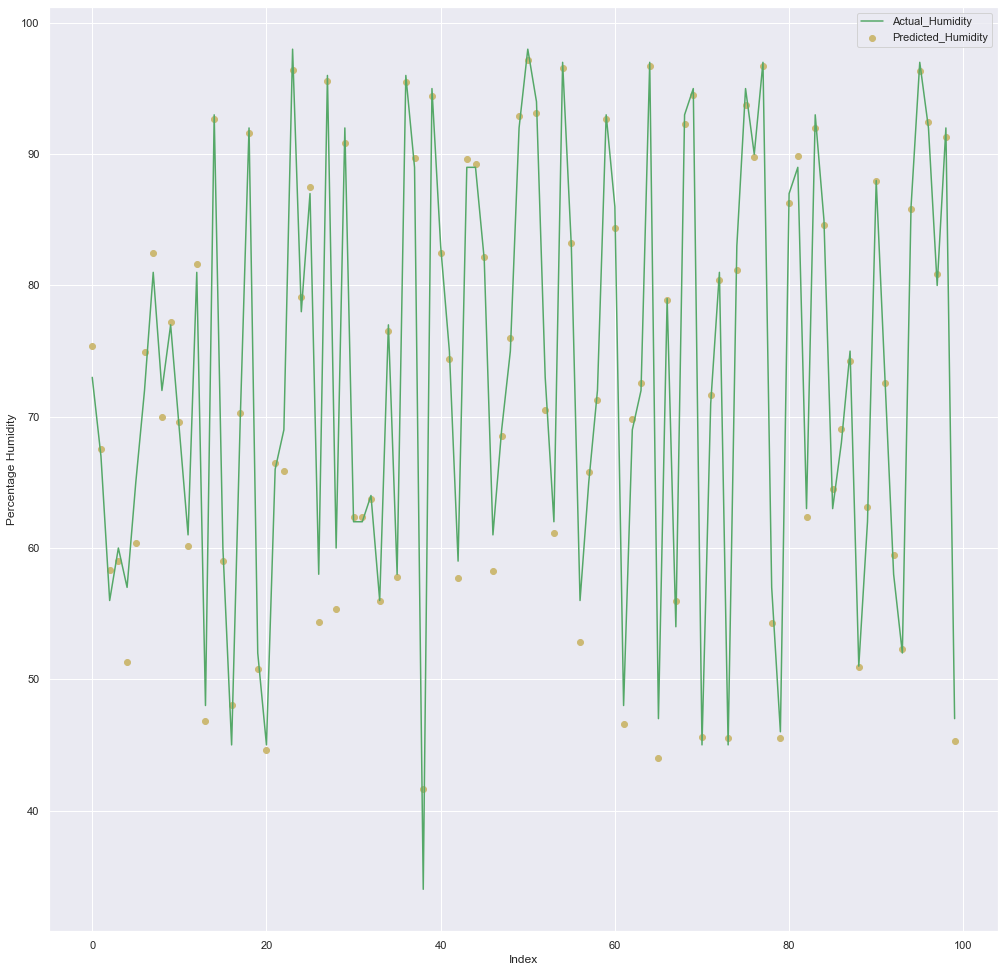

In [65]:
#RH Prediction
plt.plot(range(0,100), testl_array[0:100,1], label="Actual_Humidity", color='g')
plt.scatter(range(0,100), GBRpred[0:100,1], label="Predicted_Humidity", color='y')
plt.xlabel('Index')
plt.ylabel('Percentage Humidity')
plt.legend()
plt.show()

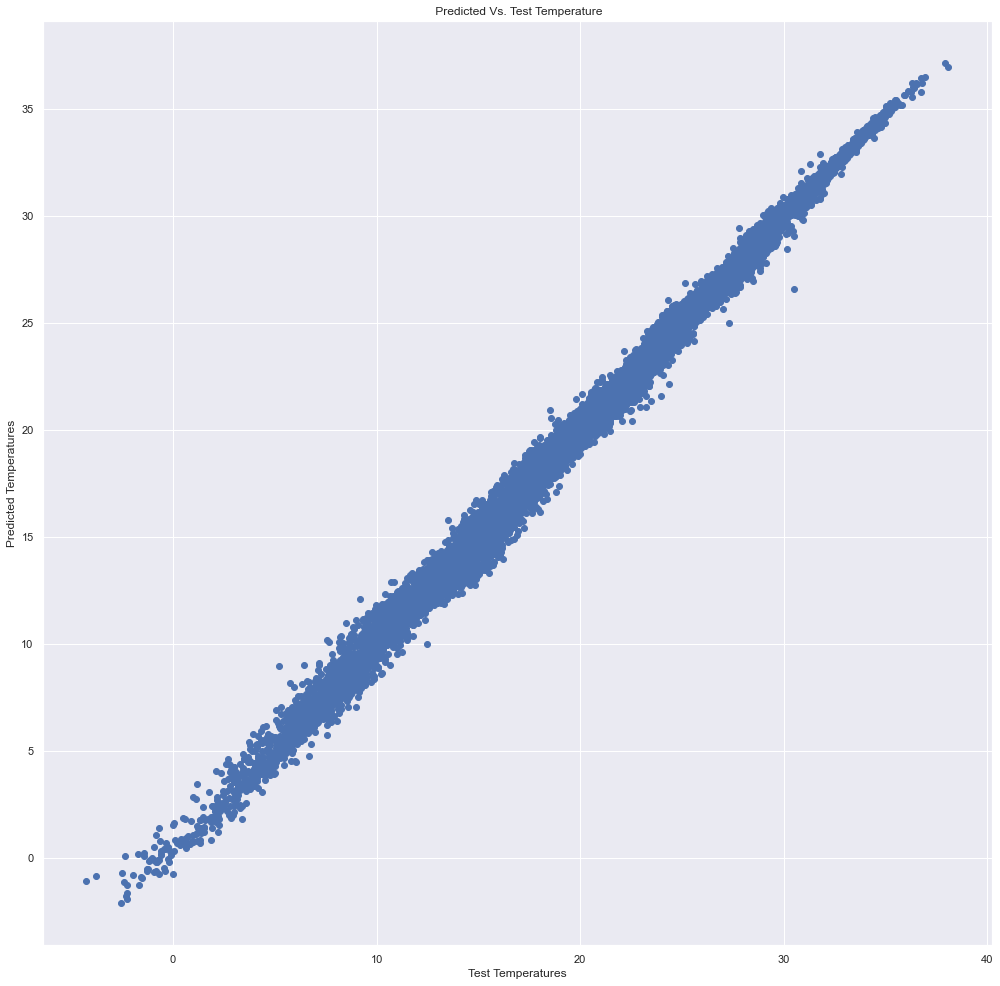

In [66]:
#Temperature Scatter Plot for predictions
plt.scatter(testl_array[:,0], GBRpred[:,0])
plt.ylabel("Predicted Temperatures")
plt.xlabel("Test Temperatures")
plt.title(" Predicted Vs. Test Temperature")
plt.show()

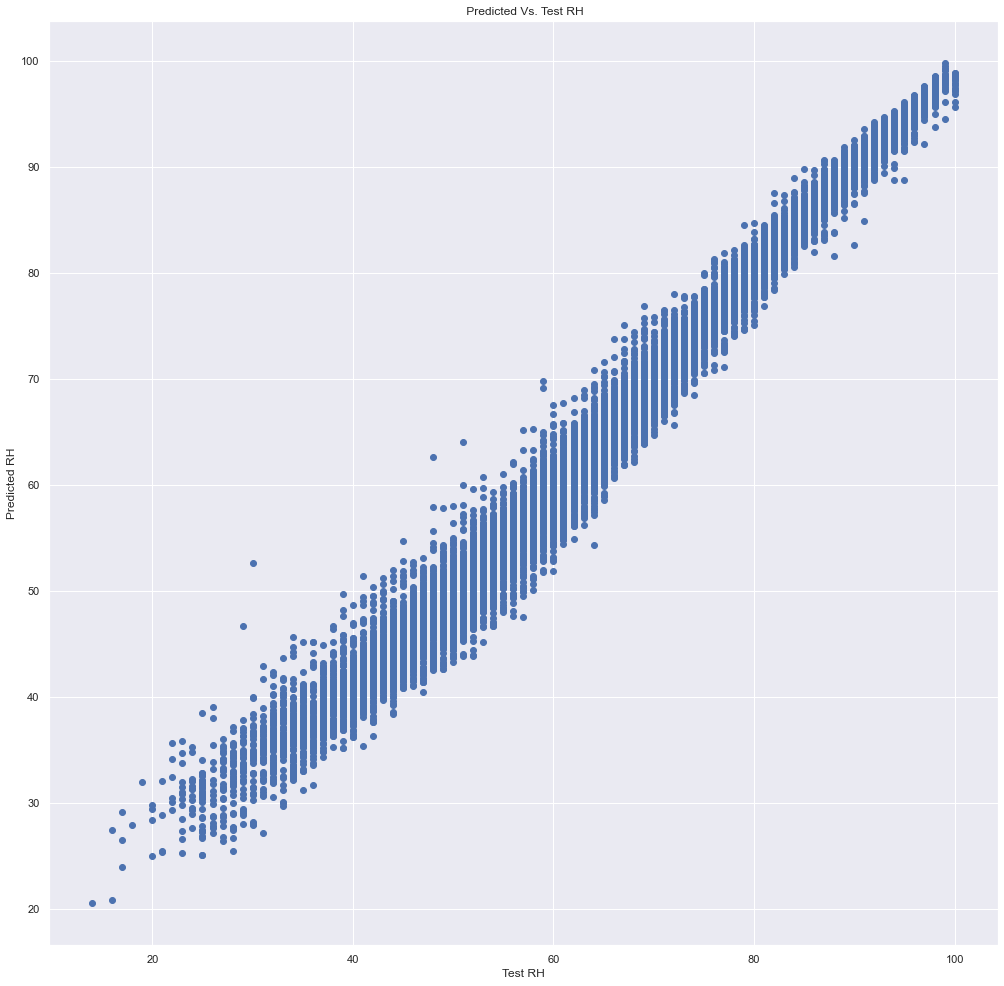

In [67]:
#RH Scatter Plot for predictions
plt.scatter(testl_array[:,1], GBRpred[:,1])
plt.ylabel("Predicted RH")
plt.xlabel("Test RH")
plt.title(" Predicted Vs. Test RH")
plt.show()

<h1>Gradient Boostes Trees - LightGBM</h1>

In [68]:
model_lgb = MultiOutputRegressor(lgb.LGBMRegressor(random_state=41), n_jobs=-1)
model_lgb.fit(trainf_array_scaled, trainl_array)

MultiOutputRegressor(estimator=LGBMRegressor(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=41, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=True,
                                             subsample=1.0,
                                             subsample_for_bin=200000,
                     

In [69]:
LGBpred = model_lgb.predict(testf_array_scaled)

In [70]:
#Model Evaluation

mse_temp = mean_squared_error(testl_array[:,0], LGBpred[:,0])
print("Mean Squared Error for Temperature is : ", mse_temp)

mse_humidity = mean_squared_error(testl_array[:,1], LGBpred[:,1])
print("Mean Squared Error for Relative Humidity is : ", mse_humidity)

rmse_temp = math.sqrt(mean_squared_error(testl_array[:,0], LGBpred[:,0]))
print("Root Mean Squared Error for Temperature is : ", rmse_temp)

rmse_humidity = math.sqrt(mean_squared_error(testl_array[:,1], LGBpred[:,1]))
print("Root Mean Squared Error for Relative Humidity is : ", rmse_humidity)

exp_var_score_temp = explained_variance_score(testl_array[:,0], LGBpred[:,0])
print("The Explained variance score Temperature is {}".format(exp_var_score_temp))

exp_var_score_humidity = explained_variance_score(testl_array[:,1], LGBpred[:,1])
print("The Explained variance score in terms of Relative Humidity is {}".format(exp_var_score_humidity))

mae_temp = mean_absolute_error(testl_array[:,0], LGBpred[:,0])
print("Explained Variance Score for Temperature is ", mae_temp)

mae_hum = mean_absolute_error(testl_array[:,1], LGBpred[:,1])
print("Explained Variance Score for Relative Humidity is ", mae_hum)

mean_abs_perc_error_temp = mean_absolute_percentage_error(testl_array[:,0], LGBpred[:,0])
print("The mean absolute percentage error for Temperature is" ,mean_abs_perc_error_temp)

mean_abs_perc_error_humidity = mean_absolute_percentage_error(testl_array[:,1], LGBpred[:,1])
print("The mean absolute percentage error for Relative Humidity is" ,mean_abs_perc_error_humidity)

Mean Squared Error for Temperature is :  0.07829868794607751
Mean Squared Error for Relative Humidity is :  0.8078769280297866
Root Mean Squared Error for Temperature is :  0.27981902713374857
Root Mean Squared Error for Relative Humidity is :  0.898819741677822
The Explained variance score Temperature is 0.9980254235822068
The Explained variance score in terms of Relative Humidity is 0.9974675512827723
Explained Variance Score for Temperature is  0.1918676768015798
Explained Variance Score for Relative Humidity is  0.5961751869917571
The mean absolute percentage error for Temperature is 2.73355517934084
The mean absolute percentage error for Relative Humidity is 1.0256503272653266


In [71]:
ModelMetrics= ModelMetrics.append([['Gradient Boosted Trees - LGB',mse_temp,mse_humidity,rmse_temp,rmse_humidity,exp_var_score_temp,exp_var_score_humidity,mae_temp,mae_hum,mean_abs_perc_error_temp,mean_abs_perc_error_humidity]])

In [72]:
ModelMetrics

0     1      2     3     4     5     6     7   \
0             Linear Regression  0.21  23.61  0.45  4.86  0.99  0.93  0.33   
0                KNN Regression  0.88  21.92  0.94  4.68  0.98  0.93  0.69   
0               SVR-Multioutput  0.22  24.60  0.47  4.96  0.99  0.92  0.33   
0            SVR-RegressorChain  0.22  24.45  0.47  4.95  0.99  0.92  0.33   
0        Decison Tree Regressor  0.33   1.61  0.58  1.27  0.99  0.99  0.34   
0        Gradient Boosted Trees  0.17   2.93  0.41  1.71  1.00  0.99  0.30   
0  Gradient Boosted Trees - LGB  0.08   0.81  0.28  0.90  1.00  1.00  0.19   

     8     9     10  
0  3.35  3.30  5.46  
0  3.33  5.81  5.08  
0  3.26  3.62  5.51  
0  3.28  3.66  5.48  
0  0.67  2.98  1.21  
0  1.11  3.00  1.96  
0  0.60  2.73  1.03

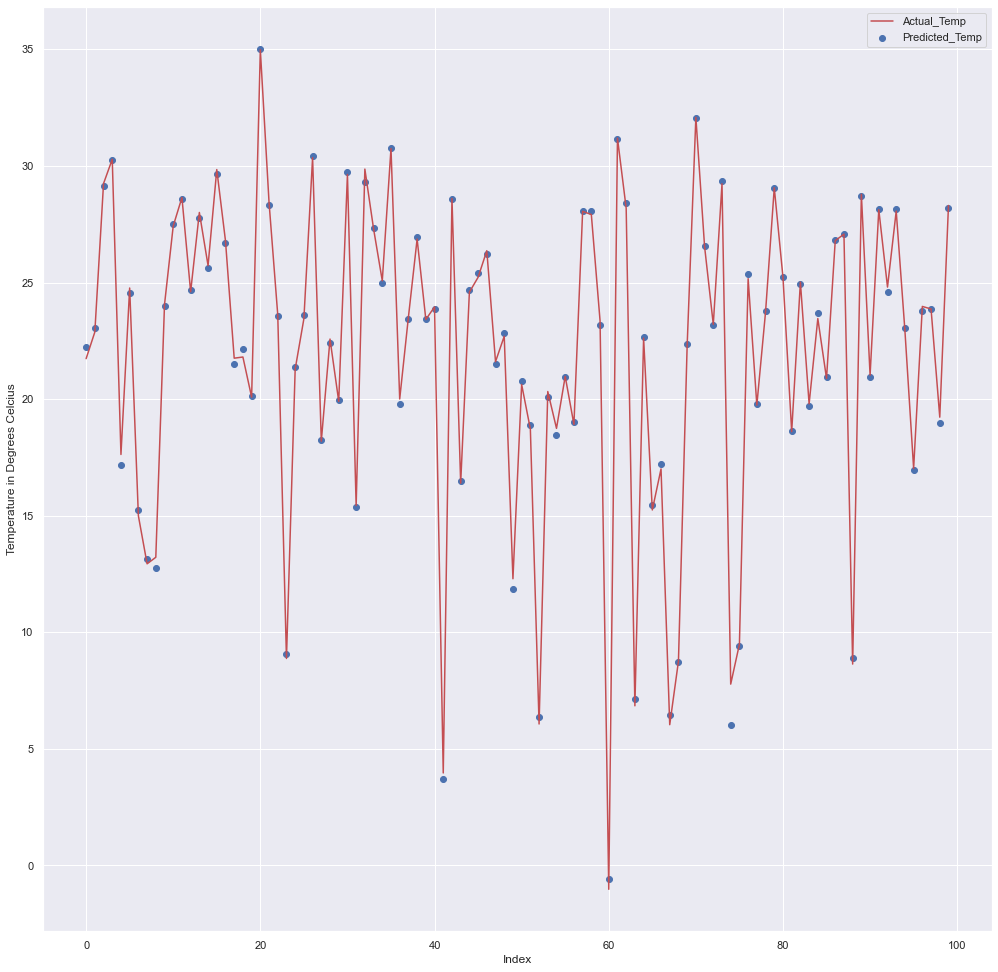

In [73]:
#Temperature Prediction
plt.plot(range(0,100), testl_array[0:100,0], label="Actual_Temp", color='r')
plt.scatter(range(0,100), LGBpred[0:100,0], label="Predicted_Temp", color='b')
plt.xlabel('Index')
plt.ylabel('Temperature in Degrees Celcius')
plt.legend()
plt.show()

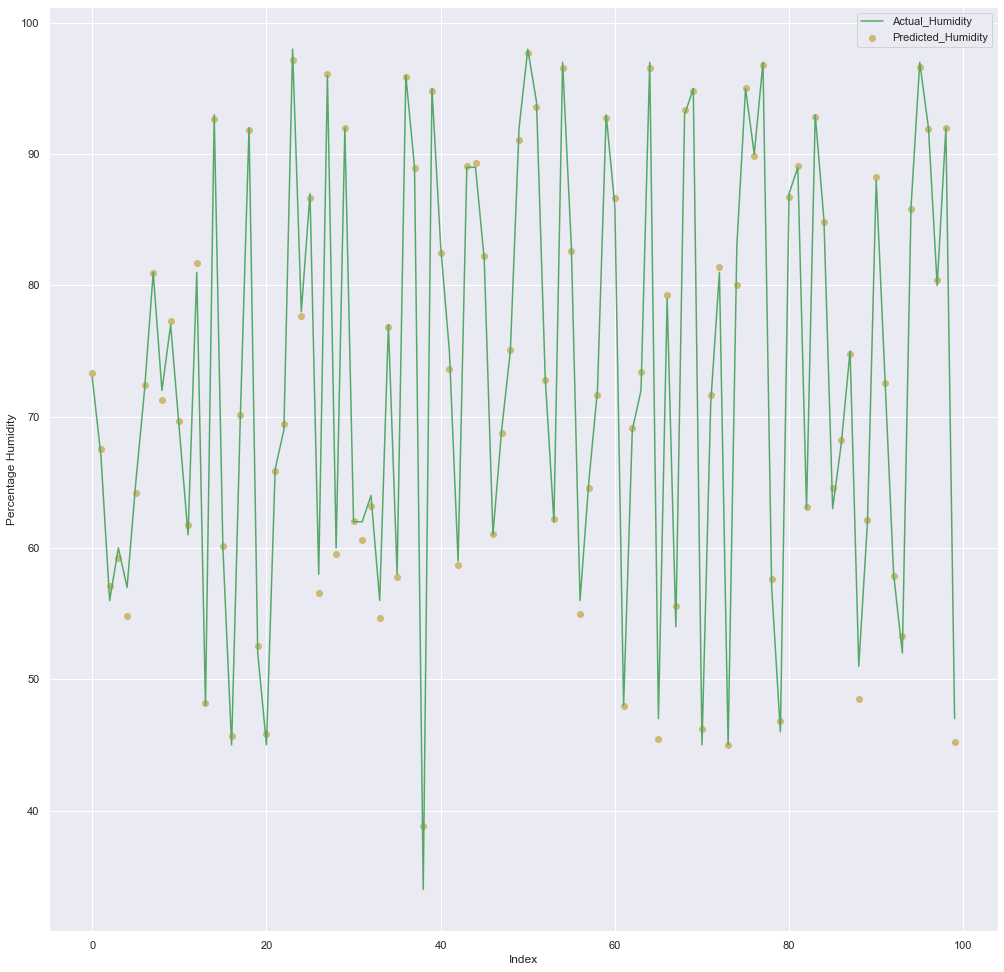

In [74]:
#RH Prediction
plt.plot(range(0,100), testl_array[0:100,1], label="Actual_Humidity", color='g')
plt.scatter(range(0,100), LGBpred[0:100,1], label="Predicted_Humidity", color='y')
plt.xlabel('Index')
plt.ylabel('Percentage Humidity')
plt.legend()
plt.show()

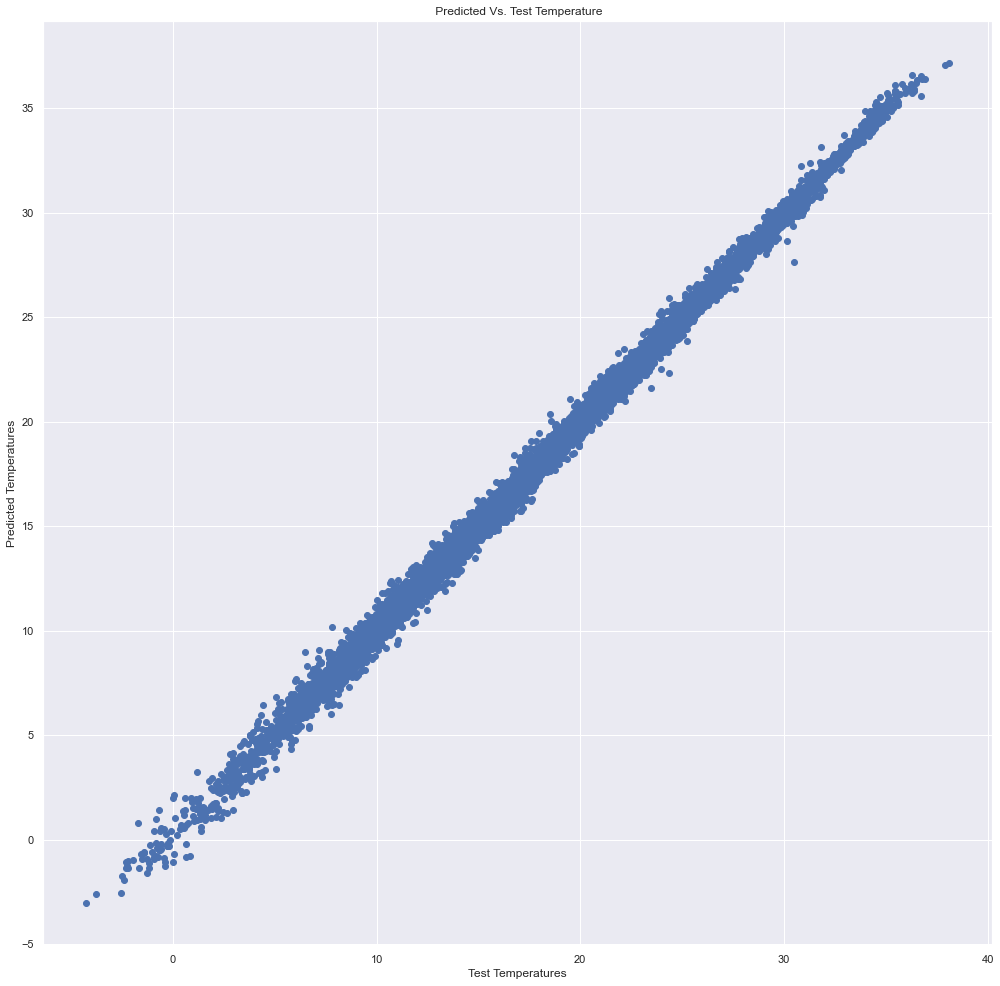

In [75]:
#Temperature Scatter Plot for predictions
plt.scatter(testl_array[:,0], LGBpred[:,0])
plt.ylabel("Predicted Temperatures")
plt.xlabel("Test Temperatures")
plt.title(" Predicted Vs. Test Temperature")
plt.show()

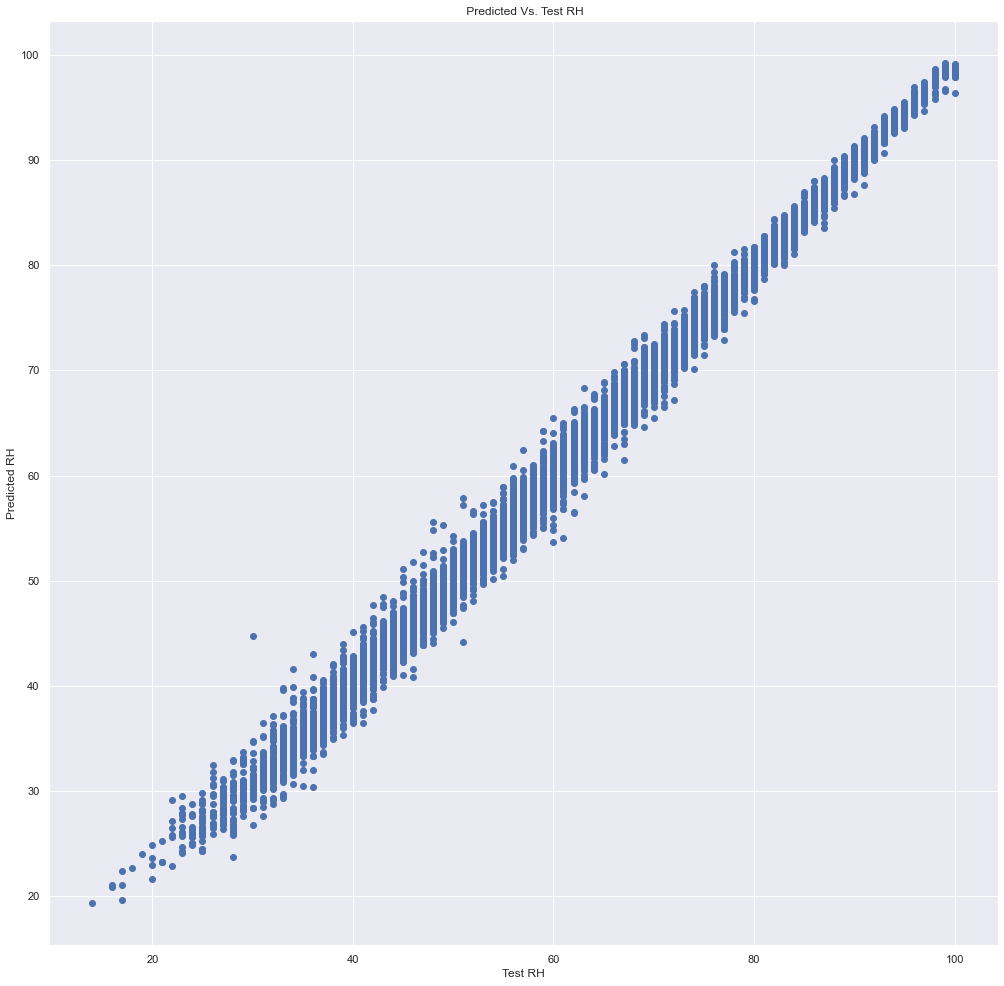

In [76]:
#RH Scatter Plot for predictions
plt.scatter(testl_array[:,1], LGBpred[:,1])
plt.ylabel("Predicted RH")
plt.xlabel("Test RH")
plt.title(" Predicted Vs. Test RH")
plt.show()

<h1> Random Forest Model </h1>

In [78]:
#model = RandomForestRegressor(n_estimators=100, bootstrap='TRUE', max_depth=20)
model_RF = RandomForestRegressor(n_jobs=-1, random_state=35)
model_RF.fit(trainf_array,trainl_array)


#parameters used by the current random forest model initiated. 
from pprint import pprint
print('Parameters currently in use:\n')
pprint(model_RF.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 35,
 'verbose': 0,
 'warm_start': False}


In [79]:
RFpred = model_RF.predict(testf_array)

In [80]:
#Model Evaluation

mse_temp = mean_squared_error(testl_array[:,0], RFpred[:,0])
print("Mean Squared Error for Temperature is : ", mse_temp)

mse_humidity = mean_squared_error(testl_array[:,1], RFpred[:,1])
print("Mean Squared Error for Relative Humidity is : ", mse_humidity)

rmse_temp = math.sqrt(mean_squared_error(testl_array[:,0], RFpred[:,0]))
print("Root Mean Squared Error for Temperature is : ", rmse_temp)

rmse_humidity = math.sqrt(mean_squared_error(testl_array[:,1], RFpred[:,1]))
print("Root Mean Squared Error for Relative Humidity is : ", rmse_humidity)

exp_var_score_temp = explained_variance_score(testl_array[:,0], RFpred[:,0])
print("The Explained variance score Temperature is {}".format(exp_var_score_temp))

exp_var_score_humidity = explained_variance_score(testl_array[:,1], RFpred[:,1])
print("The Explained variance score in terms of Relative Humidity is {}".format(exp_var_score_humidity))

mae_temp = mean_absolute_error(testl_array[:,0], RFpred[:,0])
print("Explained Variance Score for Temperature is ", mae_temp)

mae_hum = mean_absolute_error(testl_array[:,1], RFpred[:,1])
print("Explained Variance Score for Relative Humidity is ", mae_hum)

mean_abs_perc_error_temp = mean_absolute_percentage_error(testl_array[:,0], RFpred[:,0])
print("The mean absolute percentage error for Temperature is" ,mean_abs_perc_error_temp)

mean_abs_perc_error_humidity = mean_absolute_percentage_error(testl_array[:,1], RFpred[:,1])
print("The mean absolute percentage error for Relative Humidity is" ,mean_abs_perc_error_humidity)

Mean Squared Error for Temperature is :  0.10690899640700097
Mean Squared Error for Relative Humidity is :  0.4812867436422099
Root Mean Squared Error for Temperature is :  0.32696941203574525
Root Mean Squared Error for Relative Humidity is :  0.6937483287491293
The Explained variance score Temperature is 0.9973046016152061
The Explained variance score in terms of Relative Humidity is 0.9984904946613009
Explained Variance Score for Temperature is  0.19927596226732866
Explained Variance Score for Relative Humidity is  0.3816113709441685
The mean absolute percentage error for Temperature is 2.0283611717550016
The mean absolute percentage error for Relative Humidity is 0.6935920178001578


In [81]:
ModelMetrics= ModelMetrics.append([['Random Forest Regression',mse_temp,mse_humidity,rmse_temp,rmse_humidity,exp_var_score_temp,exp_var_score_humidity,mae_temp,mae_hum,mean_abs_perc_error_temp,mean_abs_perc_error_humidity]])

In [82]:
ModelMetrics

0     1      2     3     4     5     6     7   \
0             Linear Regression  0.21  23.61  0.45  4.86  0.99  0.93  0.33   
0                KNN Regression  0.88  21.92  0.94  4.68  0.98  0.93  0.69   
0               SVR-Multioutput  0.22  24.60  0.47  4.96  0.99  0.92  0.33   
0            SVR-RegressorChain  0.22  24.45  0.47  4.95  0.99  0.92  0.33   
0        Decison Tree Regressor  0.33   1.61  0.58  1.27  0.99  0.99  0.34   
0        Gradient Boosted Trees  0.17   2.93  0.41  1.71  1.00  0.99  0.30   
0  Gradient Boosted Trees - LGB  0.08   0.81  0.28  0.90  1.00  1.00  0.19   
0      Random Forest Regression  0.11   0.48  0.33  0.69  1.00  1.00  0.20   

     8     9     10  
0  3.35  3.30  5.46  
0  3.33  5.81  5.08  
0  3.26  3.62  5.51  
0  3.28  3.66  5.48  
0  0.67  2.98  1.21  
0  1.11  3.00  1.96  
0  0.60  2.73  1.03  
0  0.38  2.03  0.69

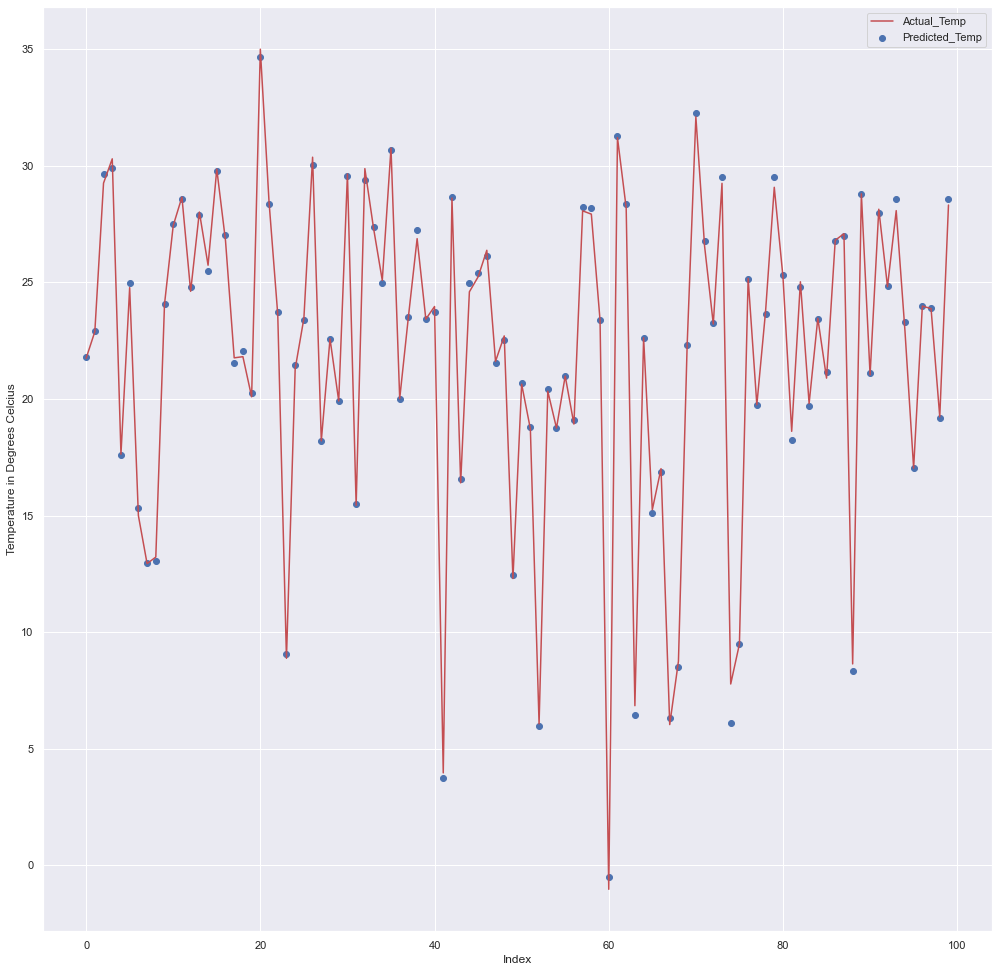

In [83]:
#Temperature Prediction
plt.plot(range(0,100), testl_array[0:100,0], label="Actual_Temp", color='r')
plt.scatter(range(0,100), RFpred[0:100,0], label="Predicted_Temp", color='b')
plt.xlabel('Index')
plt.ylabel('Temperature in Degrees Celcius')
plt.legend()
plt.show()

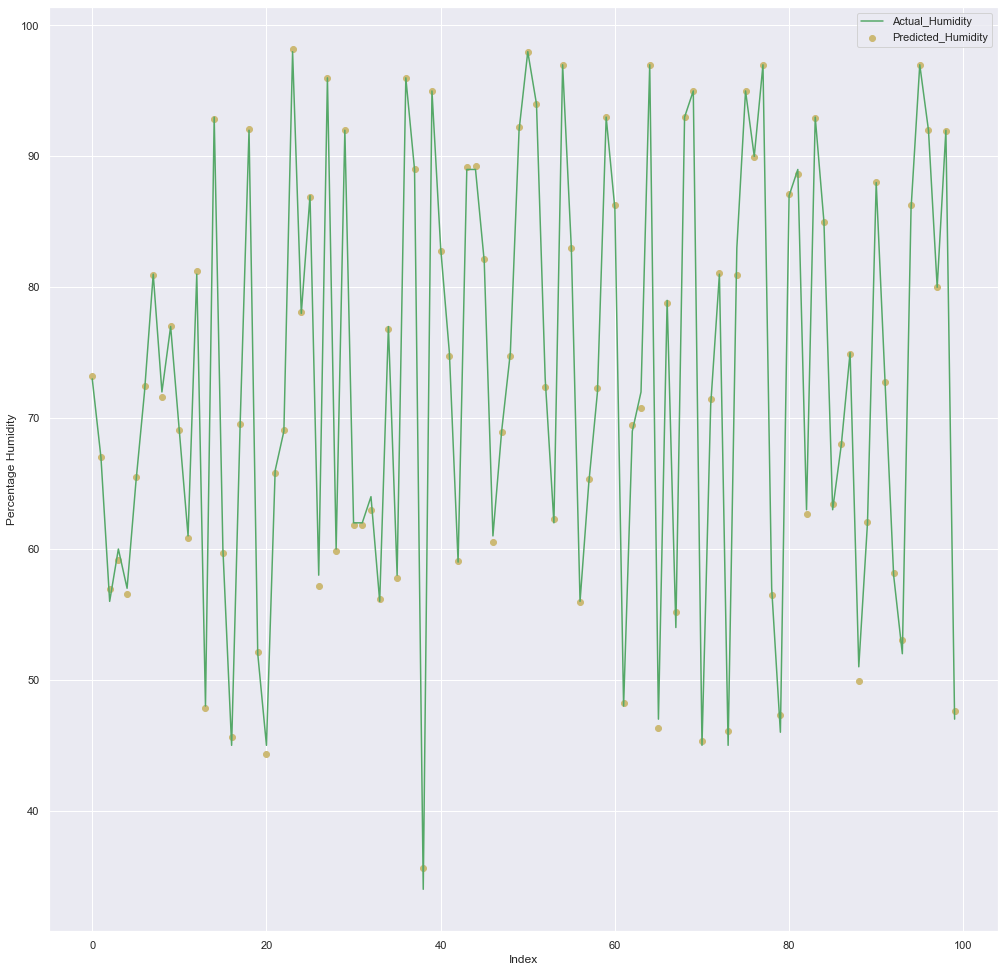

In [84]:
#RH Prediction
plt.plot(range(0,100), testl_array[0:100,1], label="Actual_Humidity", color='g')
plt.scatter(range(0,100), RFpred[0:100,1], label="Predicted_Humidity", color='y')
plt.xlabel('Index')
plt.ylabel('Percentage Humidity')
plt.legend()
plt.show()

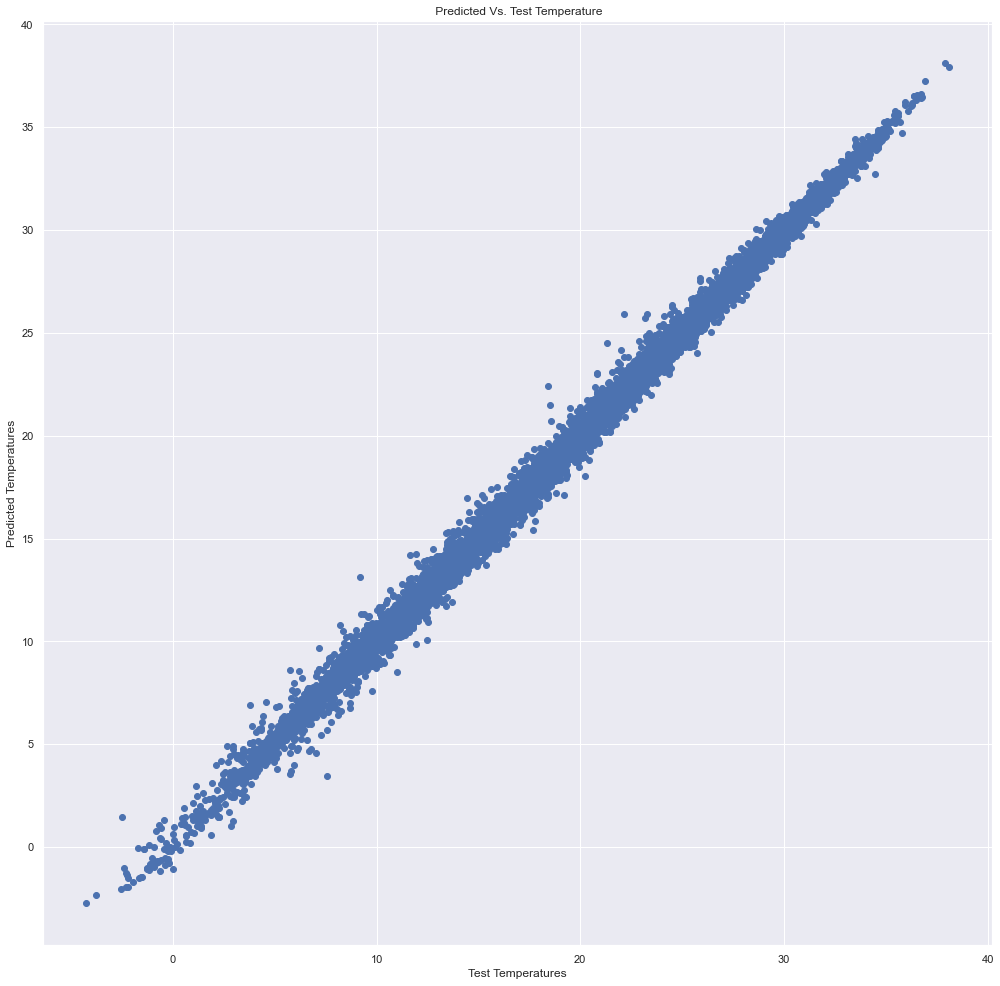

In [85]:
#Temperature Scatter Plot for predictions
plt.scatter(testl_array[:,0], RFpred[:,0])
plt.ylabel("Predicted Temperatures")
plt.xlabel("Test Temperatures")
plt.title(" Predicted Vs. Test Temperature")
plt.show()

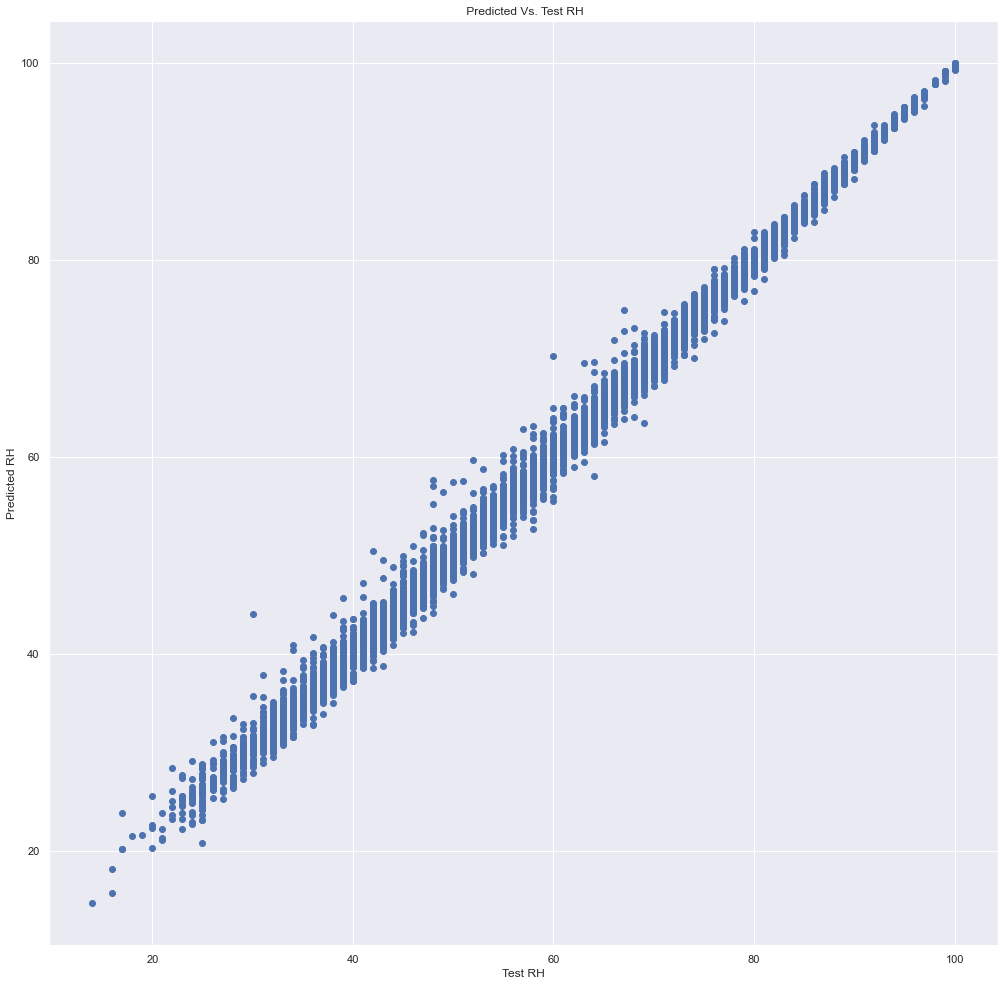

In [86]:
#RH Scatter Plot for predictions
plt.scatter(testl_array[:,1], RFpred[:,1])
plt.ylabel("Predicted RH")
plt.xlabel("Test RH")
plt.title(" Predicted Vs. Test RH")
plt.show()

# Overall Predictions

In [87]:
Final_Predictions = pd.DataFrame({'Test_Temp':testl_array[:,0],'Test_RH':testl_array[:,1],'Linear_Reg_temp':LRpred[:,0],'Linear_Reg_RH':LRpred[:,1], 'KNN_Reg_temp':KNNpred[:,0], 'KNN_Reg_RH':KNNpred[:,1], 'SVR_temp':SVRpred[:,0], 'SVR_RH':SVRpred[:,1], 'RCSVR_temp':RCSVRpred[:,0], 'RCSVR_RH':RCSVRpred[:,1], 'DecisionTree_temp':DTpred[:,0], 'DecisionTree_RH': DTpred[:,1], 'GradentBoostedTree_temp':GBRpred[:,0], 'GradentBoostedTree_RH':GBRpred[:,1], 'LGB_temp':LGBpred[:,0], 'LGB_RH':LGBpred[:,1], 'RandomForest_temp':RFpred[:,0], 'RandomForest_RH':RFpred[:,1]})

In [88]:
Final_Predictions.head(25)

Test_Temp  Test_RH  Linear_Reg_temp  Linear_Reg_RH  KNN_Reg_temp  \
0       21.74     73.0            21.65          74.67         23.55   
1       22.88     67.0            22.61          66.78         23.24   
2       29.25     56.0            28.98          53.59         29.05   
3       30.29     60.0            30.60          59.82         29.80   
4       17.63     57.0            16.98          55.38         15.80   
5       24.77     65.0            24.34          68.56         23.64   
6       15.00     72.0            15.02          76.74         17.05   
7       12.94     81.0            13.03          78.72         13.67   
8       13.22     72.0            12.97          74.25         14.06   
9       24.06     77.0            23.89          78.07         24.38   
10      27.43     69.0            27.43          69.93         27.20   
11      28.65     61.0            28.06          63.00         28.73   
12      24.61     81.0            24.55          80.65         25.00   
13      28.01     48.0            27.72          49.13         27.88   
14      25.73     93.0            26.02          91.66         26.10   
15      29.85     60.0            29.93          57.58         29.56   
16      26.79     45.0            26.47          44.69         26.00   
17      21.76     70.0            21.74          69.33         22.73   
18      21.81     92.0            22.65          92.85         22.50   
19      20.09     52.0            19.82          57.04         19.11   
20      34.99     45.0            34.94          37.20         33.82   
21      28.44     66.0            28.45          66.98         28.88   
22      23.62     69.0            23.42          71.52         22.07   
23       8.88     98.0             8.58          93.37          9.67   
24      21.29     78.0            21.17          81.89         21.40   

    KNN_Reg_RH  SVR_temp  SVR_RH  RCSVR_temp  RCSVR_RH  DecisionTree_temp  \
0         65.6     21.58   75.52       21.57     75.63              22.67   
1         66.8     22.79   67.21       22.82     67.08              22.86   
2         61.6     28.89   53.65       28.87     54.20              29.69   
3         59.6     30.65   59.32       30.67     59.50              29.49   
4         45.0     17.11   58.23       17.12     58.00              17.22   
5         66.2     24.47   68.39       24.45     68.52              25.34   
6         75.6     15.03   77.11       15.01     77.23              14.73   
7         76.8     13.04   77.71       13.02     77.74              13.08   
8         65.0     13.15   74.40       13.20     74.63              13.19   
9         75.6     23.92   77.75       23.91     77.75              23.19   
10        69.8     27.43   69.72       27.42     70.01              27.43   
11        61.0     28.21   62.11       28.17     62.36              28.70   
12        82.8     24.59   80.68       24.58     80.75              24.72   
13        50.0     27.81   48.60       27.75     49.12              27.32   
14        89.0     25.95   91.20       25.94     91.55              25.75   
15        60.8     29.92   57.13       29.94     57.79              29.83   
16        47.6     26.52   43.35       26.51     44.07              27.69   
17        70.0     21.83   70.14       21.85     70.13              22.49   
18        87.8     22.66   91.37       22.70     91.48              21.72   
19        54.8     19.94   58.47       19.93     58.29              20.34   
20        45.8     34.80   36.08       34.75     37.29              34.80   
21        63.0     28.49   66.94       28.48     67.25              28.43   
22        80.6     23.48   71.23       23.46     71.33              23.69   
23        95.6      8.76   93.10        8.76     93.14               8.81   
24        81.0     21.28   80.81       21.28     80.81              21.29   

    DecisionTree_RH  GradentBoostedTree_temp  GradentBoostedTree_RH  LGB_temp  \
0              74.0                    21.73   

# Analysis of Model Performance

In [89]:
#Assign suitable columns to the dataframe that contains the metrics for the applied algorithms
ModelMetrics.columns= ['ModelName','MSE-Temp','MSE-RH','RMSE-Temp','RMSE-RH','R2Score-Temp','R2Score-RH','MAE-Temp','MAE-RH','MAPE-Temp','MAPE-RH',]

In [90]:
ModelMetrics

ModelName  MSE-Temp  MSE-RH  RMSE-Temp  RMSE-RH  \
0             Linear Regression      0.21   23.61       0.45     4.86   
0                KNN Regression      0.88   21.92       0.94     4.68   
0               SVR-Multioutput      0.22   24.60       0.47     4.96   
0            SVR-RegressorChain      0.22   24.45       0.47     4.95   
0        Decison Tree Regressor      0.33    1.61       0.58     1.27   
0        Gradient Boosted Trees      0.17    2.93       0.41     1.71   
0  Gradient Boosted Trees - LGB      0.08    0.81       0.28     0.90   
0      Random Forest Regression      0.11    0.48       0.33     0.69   

   R2Score-Temp  R2Score-RH  MAE-Temp  MAE-RH  MAPE-Temp  MAPE-RH  
0          0.99        0.93      0.33    3.35       3.30     5.46  
0          0.98        0.93      0.69    3.33       5.81     5.08  
0          0.99        0.92      0.33    3.26       3.62     5.51  
0          0.99        0.92      0.33    3.28       3.66     5.48  
0          0.99        0.99      0.34    0.67       2.98     1.21  
0          1.00        0.99      0.30    1.11       3.00     1.96  
0          1.00        1.00      0.19    0.60       2.73     1.03  
0          1.00        1.00      0.20    0.38       2.03     0.69

## Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) are considered as the suitable error metrics for this analysis.


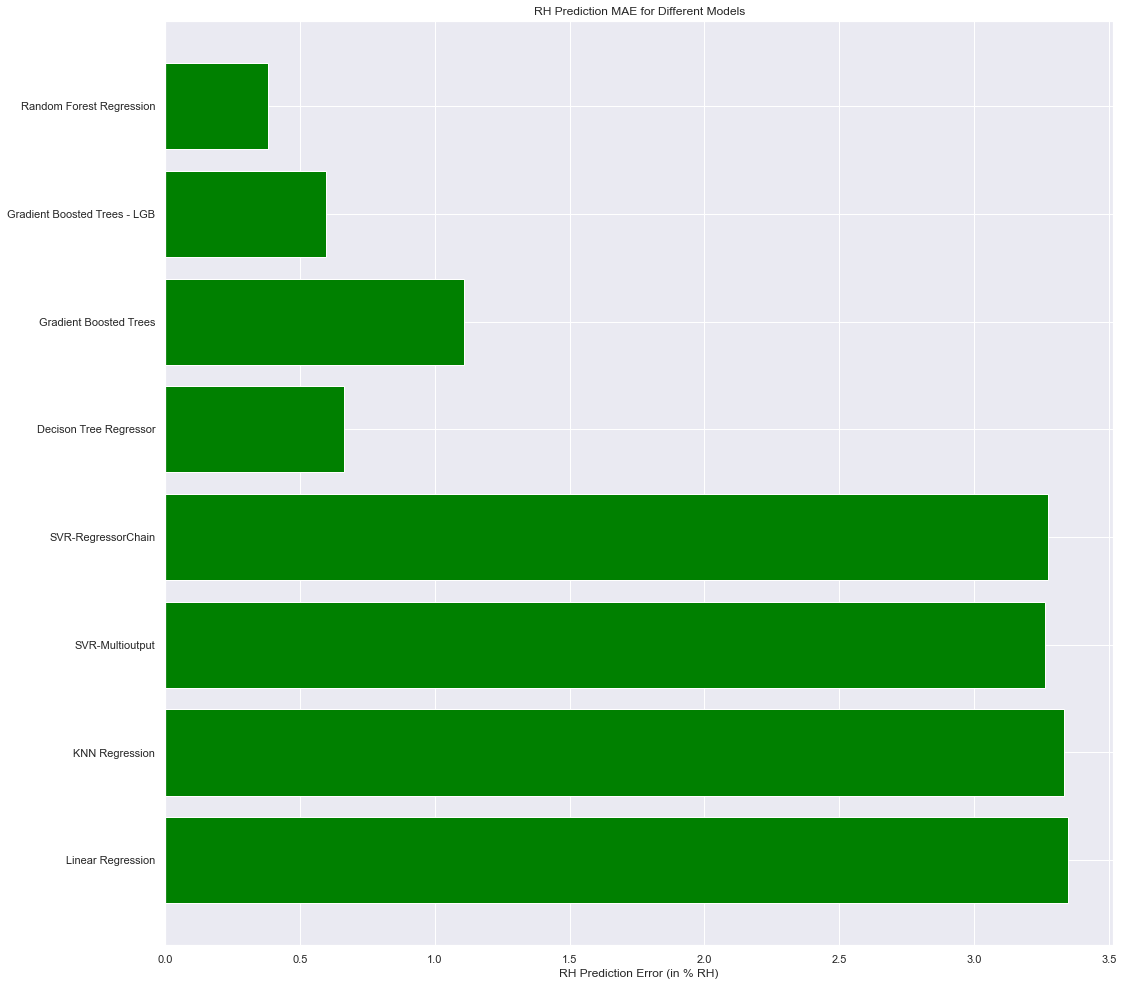

In [91]:
plt.barh(ModelMetrics['ModelName'], ModelMetrics['MAE-RH'], color ='green')
plt.xlabel('RH Prediction Error (in % RH)')
plt.title('RH Prediction MAE for Different Models')
plt.show()


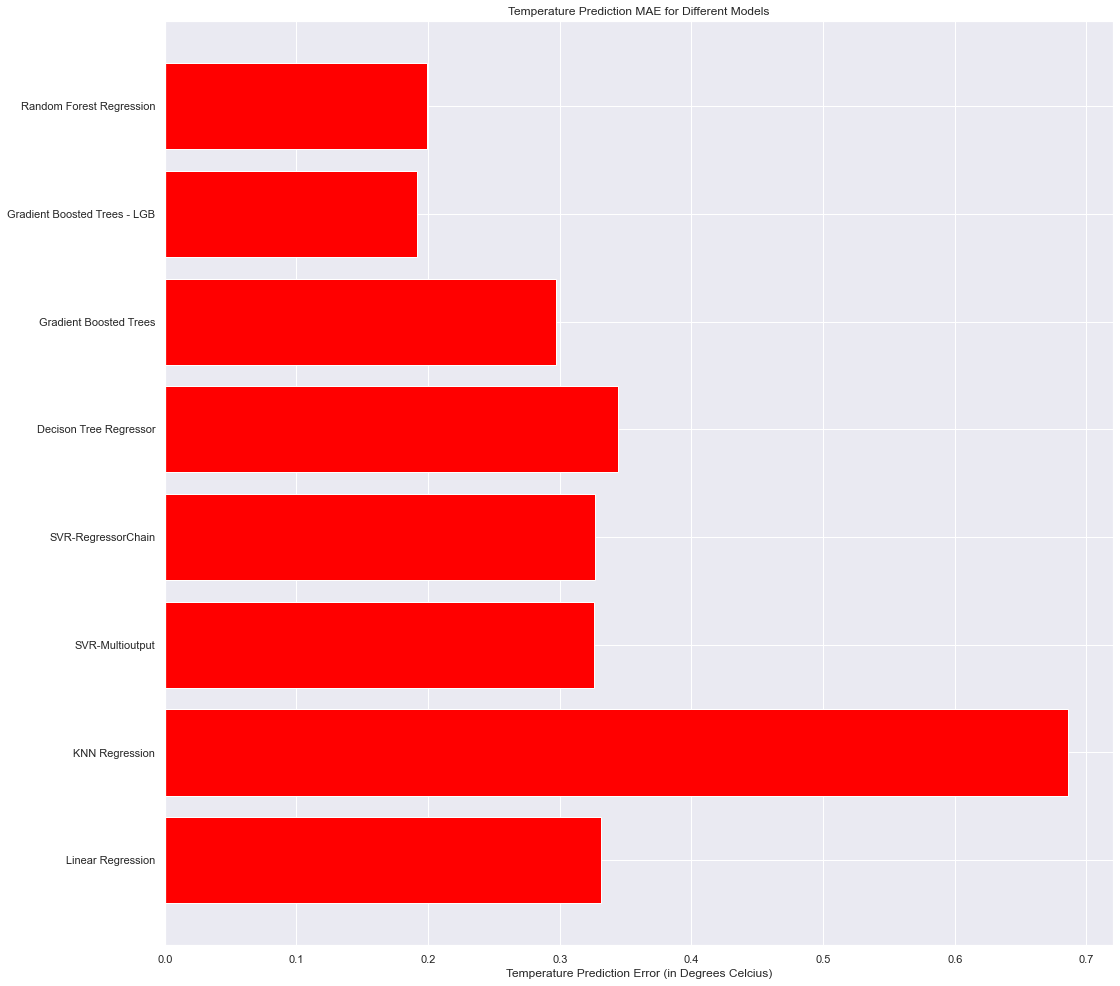

In [92]:

plt.barh(ModelMetrics['ModelName'], ModelMetrics['MAE-Temp'], color ='red')
plt.xlabel('Temperature Prediction Error (in Degrees Celcius)')
plt.title('Temperature Prediction MAE for Different Models')
plt.show()

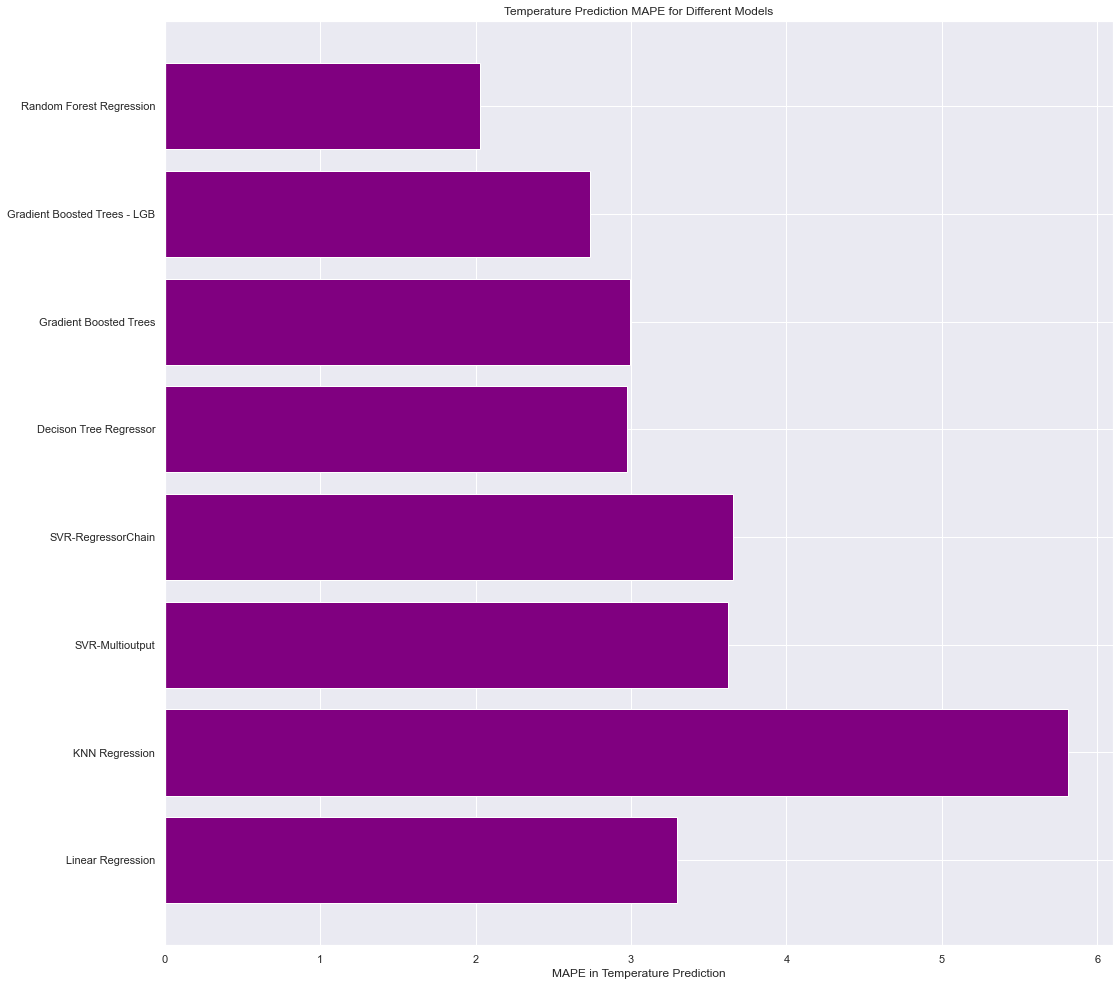

In [93]:
plt.barh(ModelMetrics['ModelName'], ModelMetrics['MAPE-Temp'], color ='purple')
plt.xlabel('MAPE in Temperature Prediction')
plt.title('Temperature Prediction MAPE for Different Models')
plt.show()

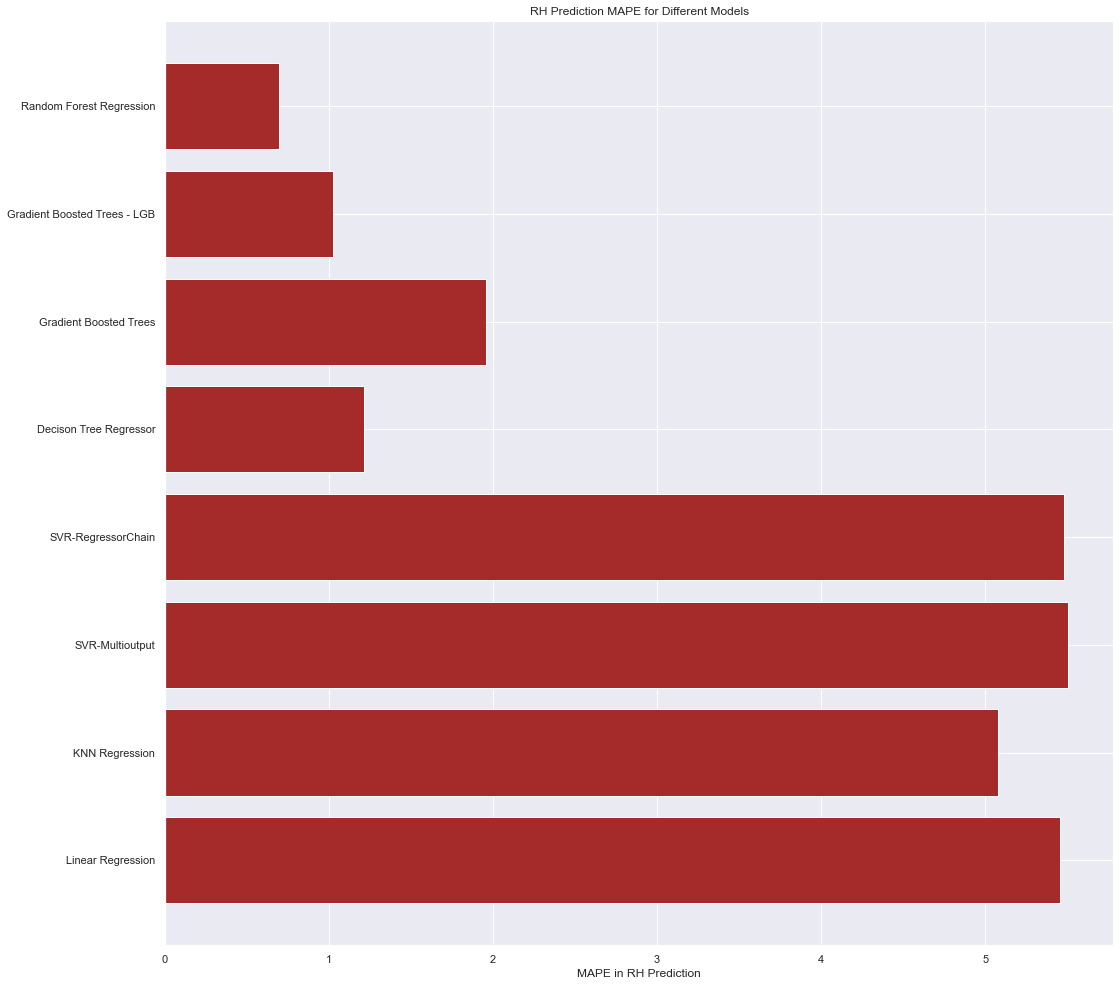

In [94]:

plt.barh(ModelMetrics['ModelName'], ModelMetrics['MAPE-RH'], color ='brown')
plt.xlabel('MAPE in RH Prediction')
plt.title('RH Prediction MAPE for Different Models')
plt.show()

In [95]:
#Save all the predicitions to a csv file for analysis
Final_Predictions.to_csv("prediction_results.csv")